Now taking the cosmic cleaned spectra, we need to resampled all spectra onto the same wavelength scale. The stars' spectral features are changing in pixel position both due to astronomical reasons (e.g. radial velocities, airmass) and imperfect tracking and pointing of the telescope (which is excellent but can still give residual shifts at the sub-pixel level). 

To do this, we need to compare the locations of absorption features (in pixel space) for all 1D spectra. This is done either by fitting models (Gaussians/Moffats) or cross-correlating all lines.

Note: currently these notebooks don't take into account the systemic velocities or radial velocities of the stars. However at the pixel scale of ACAM (3.3A/pix), the stellar systemic velocity would need to 198km/s to be measurable at 5000A. Therefore this is not a major source for concern.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import reduction_utils.wavelength_calibration as wc
import pickle
import reduction_utils.wavelength_binning as wb

import mpld3
mpld3.enable_notebook()
mpld3.disable_notebook()

In [3]:
bad_frames = []  

Again, using HAT-P-44b as an example. This time we need to also load in the array of times of the observations (called mjd), and the x positions and sky fluxes as these will also be resampled.

In [4]:
parent_direc = '/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/reduction_5_other_trace/'

star1 = pickle.load(open(parent_direc+'pickled_objects/star1_flux.pickle','rb'))
star2 = pickle.load(open(parent_direc+'pickled_objects/star2_flux.pickle','rb'))

mjd = pickle.load(open(parent_direc+'pickled_objects/mjd_time.pickle','rb'))

# make 'time' the fractional time. This is helpful for fitting the data later on.
time = mjd - int(mjd[0])

error1 = pickle.load(open(parent_direc+'pickled_objects/star1_error.pickle','rb'))
error2 = pickle.load(open(parent_direc+'pickled_objects/star2_error.pickle','rb'))

xpos1 = pickle.load(open(parent_direc+'pickled_objects/x_positions_1.pickle','rb'))
sky1 = pickle.load(open(parent_direc+'pickled_objects/sky1.pickle','rb'))

xpos2 = pickle.load(open(parent_direc+'pickled_objects/x_positions_2.pickle','rb'))
sky2 = pickle.load(open(parent_direc+'pickled_objects/sky2.pickle','rb'))

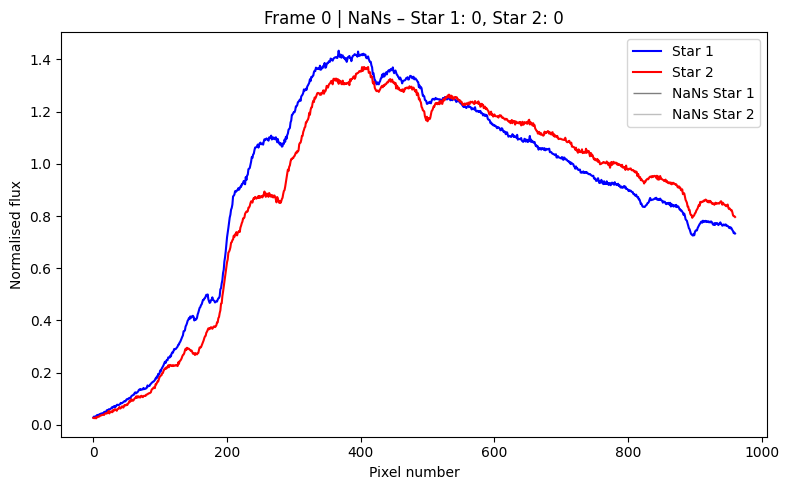

In [5]:
nframes = len(star1)
nframes = 1

import matplotlib.pyplot as plt
import numpy as np

for frame_idx in range(nframes):
    norm1 = wc.normalise(star1[frame_idx])
    norm2 = wc.normalise(star2[frame_idx])

    nan_mask1 = np.isnan(norm1)
    nan_mask2 = np.isnan(norm2)

    n_nan1 = np.sum(nan_mask1)
    n_nan2 = np.sum(nan_mask2)

    fig, ax = plt.subplots(figsize=(8, 5))

    # plot the fluxes
    ax.plot(norm1, 'b', label='Star 1')
    ax.plot(norm2, 'r', label='Star 2')

    # after the curves are drawn we know the y-limits
    ymin, ymax = ax.get_ylim()

    # vertical lines for NaNs (you can change colour/alpha/linestyle)
    ax.vlines(np.where(nan_mask1)[0], ymin, ymax,
              color='k', alpha=0.5, linewidth=1, label='NaNs Star 1')
    ax.vlines(np.where(nan_mask2)[0], ymin, ymax,
              color='grey', alpha=0.5, linewidth=1, label='NaNs Star 2')

    ax.set_ylabel('Normalised flux')
    ax.set_xlabel('Pixel number')
    ax.set_title(f'Frame {frame_idx} | NaNs – Star 1: {n_nan1}, Star 2: {n_nan2}')
    ax.legend()
    fig.tight_layout()
    plt.show()
    plt.close()

In [6]:
bad_frames = []  
good_frames = np.setdiff1d(np.arange(star1.shape[0]), bad_frames)
star1_clean = star1[good_frames, :]
star2_clean = star2[good_frames, :]
error1_clean = error1[good_frames, :]
error2_clean = error2[good_frames, :]
sky1_clean = sky1[good_frames, :]
sky2_clean = sky2[good_frames, :]
xpos1_clean = xpos1[good_frames, :]
xpos2_clean = xpos2[good_frames, :]
time_clean = time[good_frames]

Now look at reference frame first to use as many lines that are common between the 2 stars as possible.

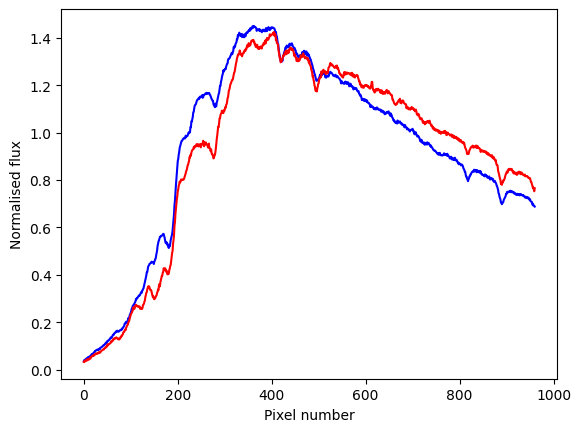

In [7]:
nframes = len(star1)

plt.figure()
plt.plot(wc.normalise(star1[nframes//2]),'b')
plt.plot(wc.normalise(star2[nframes//2]),'r')
plt.ylabel('Normalised flux')
plt.xlabel('Pixel number')
plt.show()

Now look at star 1 & 2 first and last frames to see what kind of shifts we're looking for.

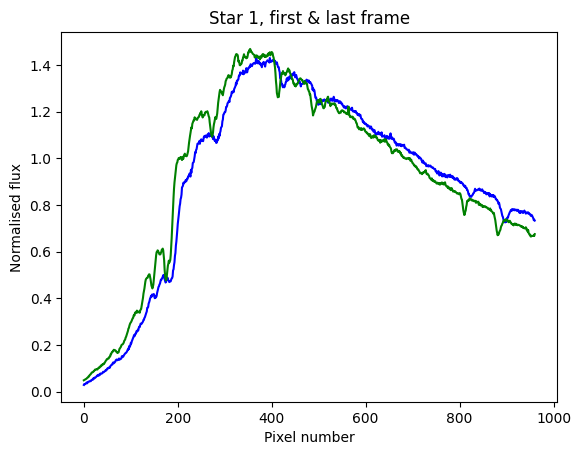

In [8]:
plt.figure()
plt.plot(wc.normalise(star1[0]),'b')
plt.plot(wc.normalise(star1[-1]),'g')
plt.ylabel('Normalised flux')
plt.xlabel('Pixel number')
plt.title('Star 1, first & last frame')
plt.show()

This depends where you are in the spectrum but something around 10 pixels should do.

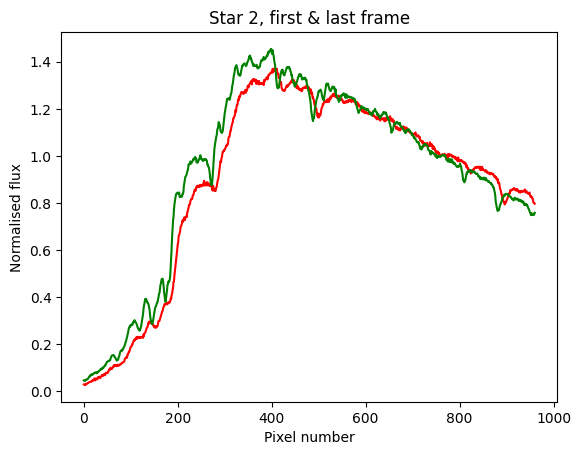

In [9]:
plt.figure()
plt.plot(wc.normalise(star2[0]),'r')
plt.plot(wc.normalise(star2[-1]),'g')
plt.ylabel('Normalised flux')
plt.xlabel('Pixel number')
plt.title('Star 2, first & last frame')
plt.show()

As above. These are actually pretty well aligned to start with and for other nights the shifts can be larger.

Plot the change over time to see the drift

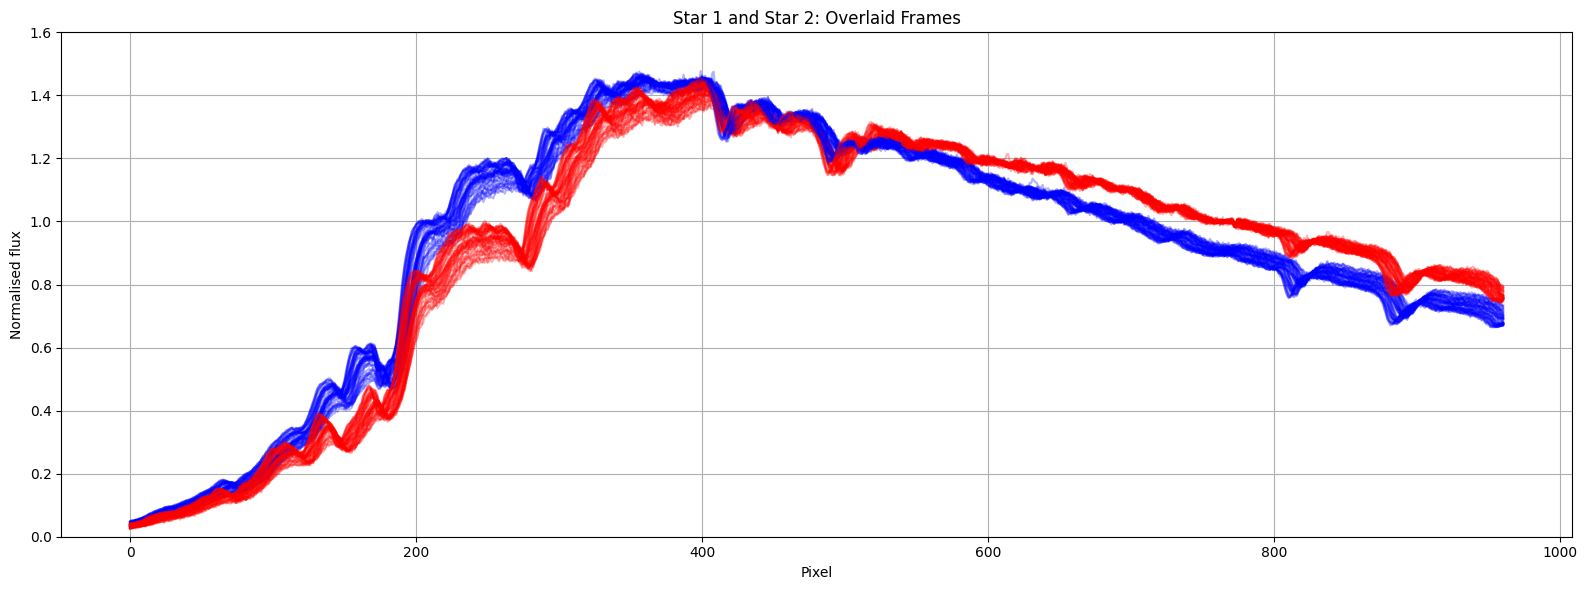

In [10]:
import matplotlib.pyplot as plt
import time as time_func

plt.figure(figsize=(16, 6))

for i in range(len(star1)):
    plt.plot(wc.normalise(star1[i]), color='blue', alpha=0.3)
    plt.plot(wc.normalise(star2[i]), color='red', alpha=0.3)

plt.title('Star 1 and Star 2: Overlaid Frames')
plt.xlabel('Pixel')
plt.ylabel('Normalised flux')
plt.ylim(0, 1.6)
plt.grid(True)
plt.tight_layout()
plt.show()

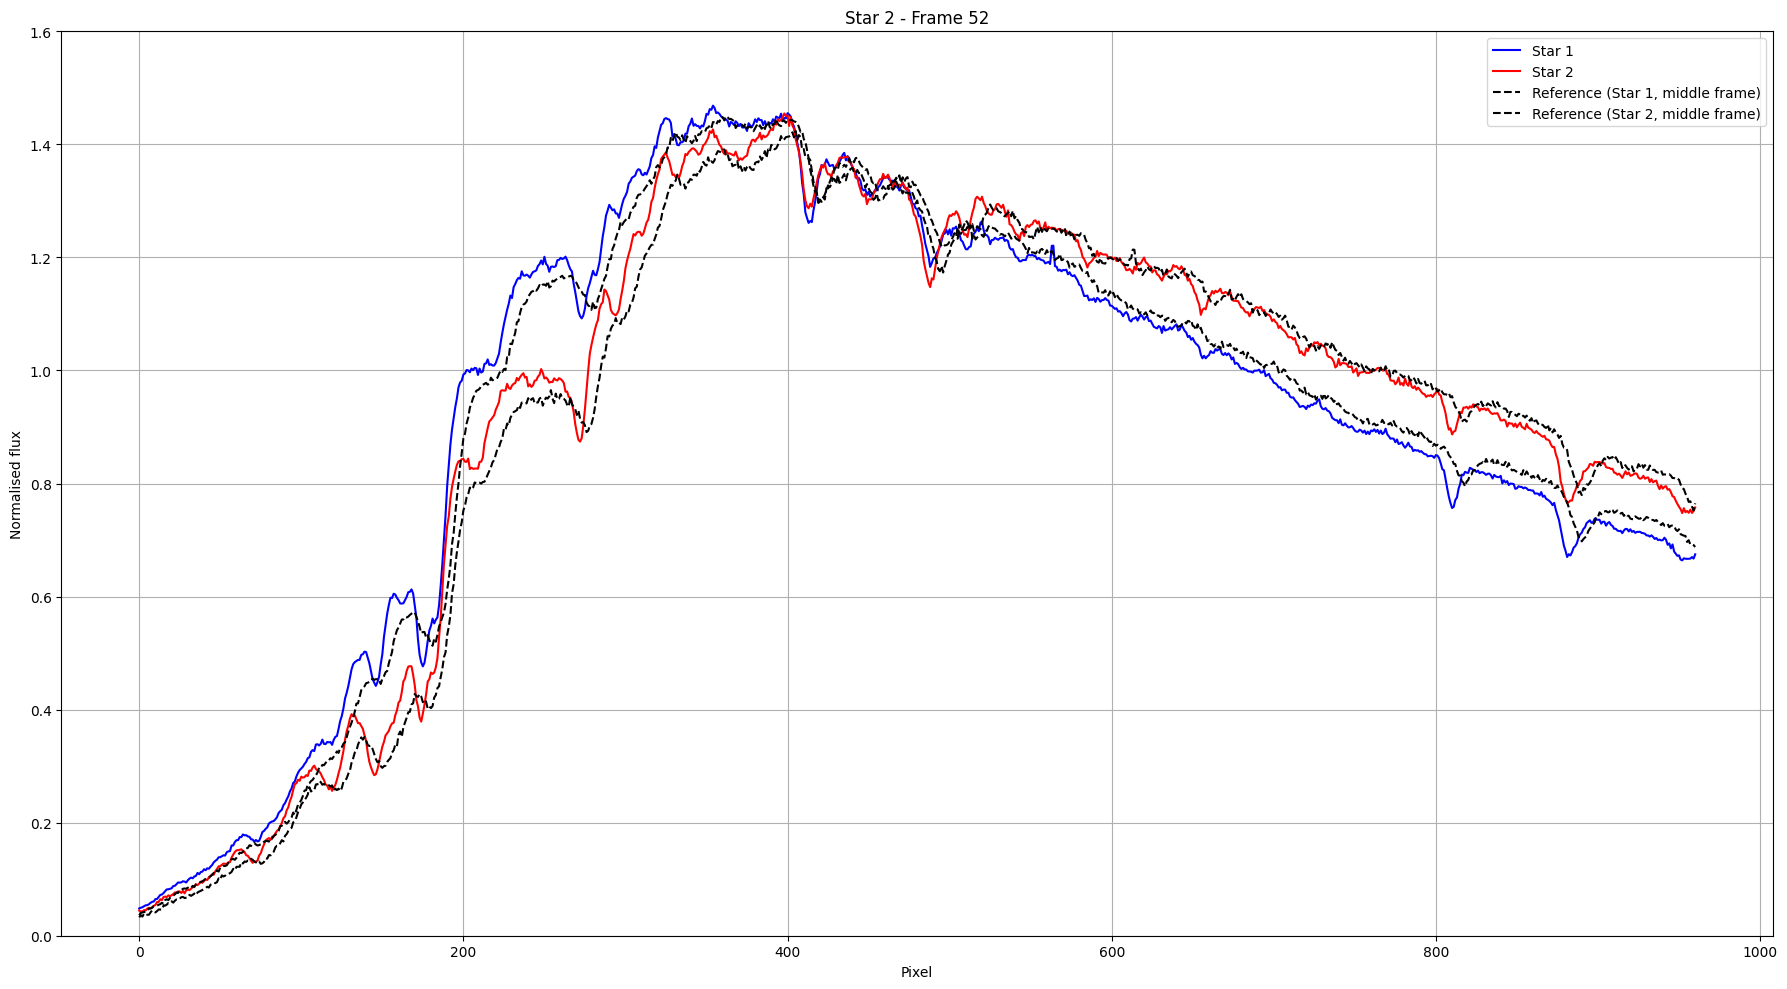

In [11]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time as time_func

reference_spectrum = wc.normalise(star1[nframes // 2])
reference_spectrum2 = wc.normalise(star2[nframes // 2])

for i in range(len(star1)):
    plt.figure(figsize=(18, 10))
    plt.plot(wc.normalise(star1[i]), 'b', label='Star 1')
    plt.plot(wc.normalise(star2[i]), 'r', label='Star 2')
    plt.plot(reference_spectrum, 'k--', label='Reference (Star 1, middle frame)')
    plt.plot(reference_spectrum2, 'k--', label='Reference (Star 2, middle frame)')
    
    plt.title(f'Star 2 - Frame {i}')
    plt.xlabel('Pixel')
    plt.ylabel('Normalised flux')
    plt.ylim(0, 1.6)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    display(plt.gcf())
    clear_output(wait=True)
    time_func.sleep(0.01)
    
    plt.close()

In [12]:
np.arange(0, 1000, 25)

array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
       325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625,
       650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950,
       975])

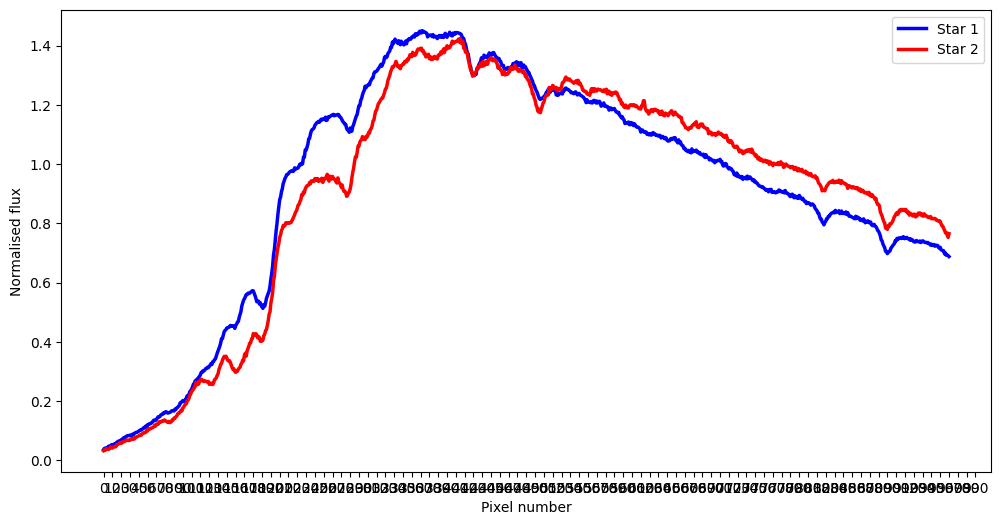

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# arrays
flux1 = wc.normalise(star1[nframes//2])
flux2 = wc.normalise(star2[nframes//2])
x = np.arange(len(flux1))  # pixel numbers

# find the difference between the two
diff = flux1 - flux2

# show plot with intersection points
plt.figure(figsize=(12, 6))
plt.plot(x, flux1, 'b-',linewidth=2.5, label='Star 1')
plt.plot(x, flux2, 'r-',linewidth=2.5, label='Star 2')

plt.xlabel('Pixel number')
plt.ylabel('Normalised flux')
plt.legend()
#plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, 1000, 10))  # ticks every 50 pixels from 0 to 1000
plt.savefig('spectra_intersections.png', dpi=300, bbox_inches='tight')
plt.show()


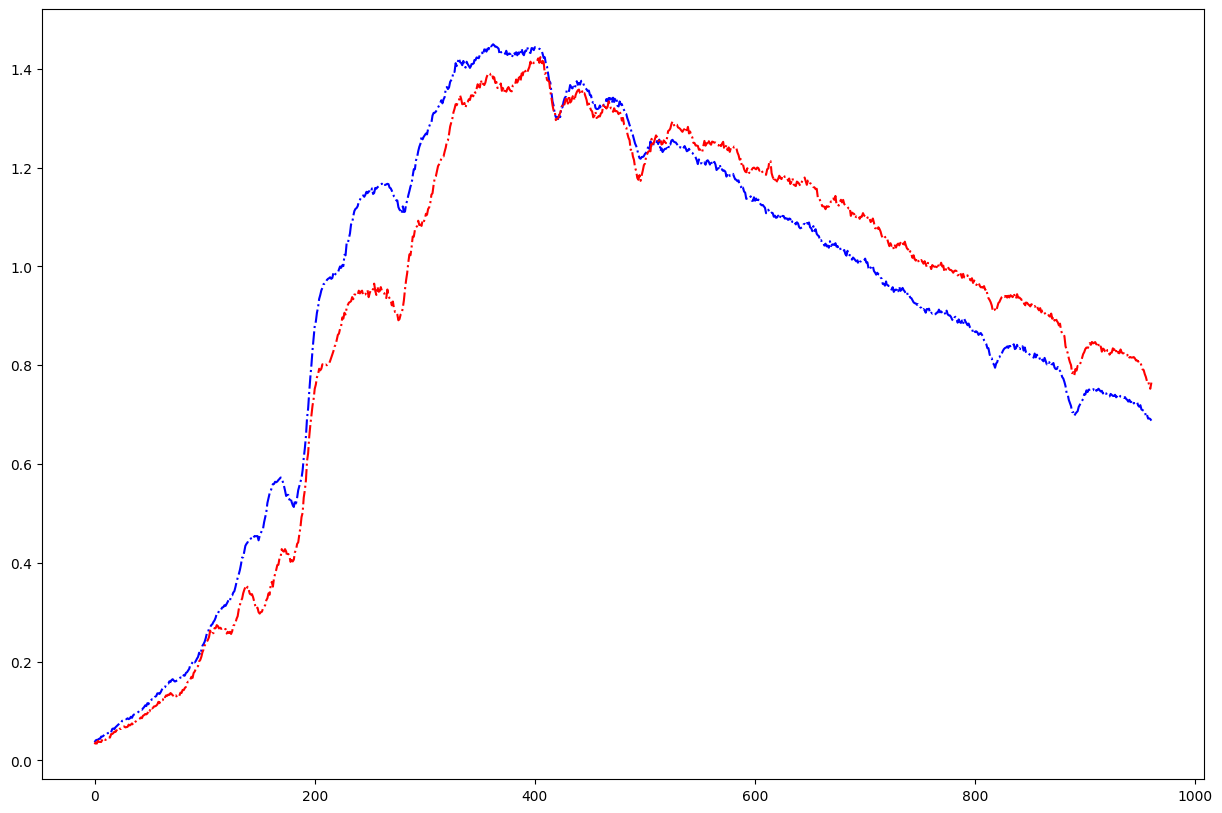

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(x, flux1, 'b-.', label='Star 1')
plt.plot(x, flux2, 'r-.', label='Star 2')

50


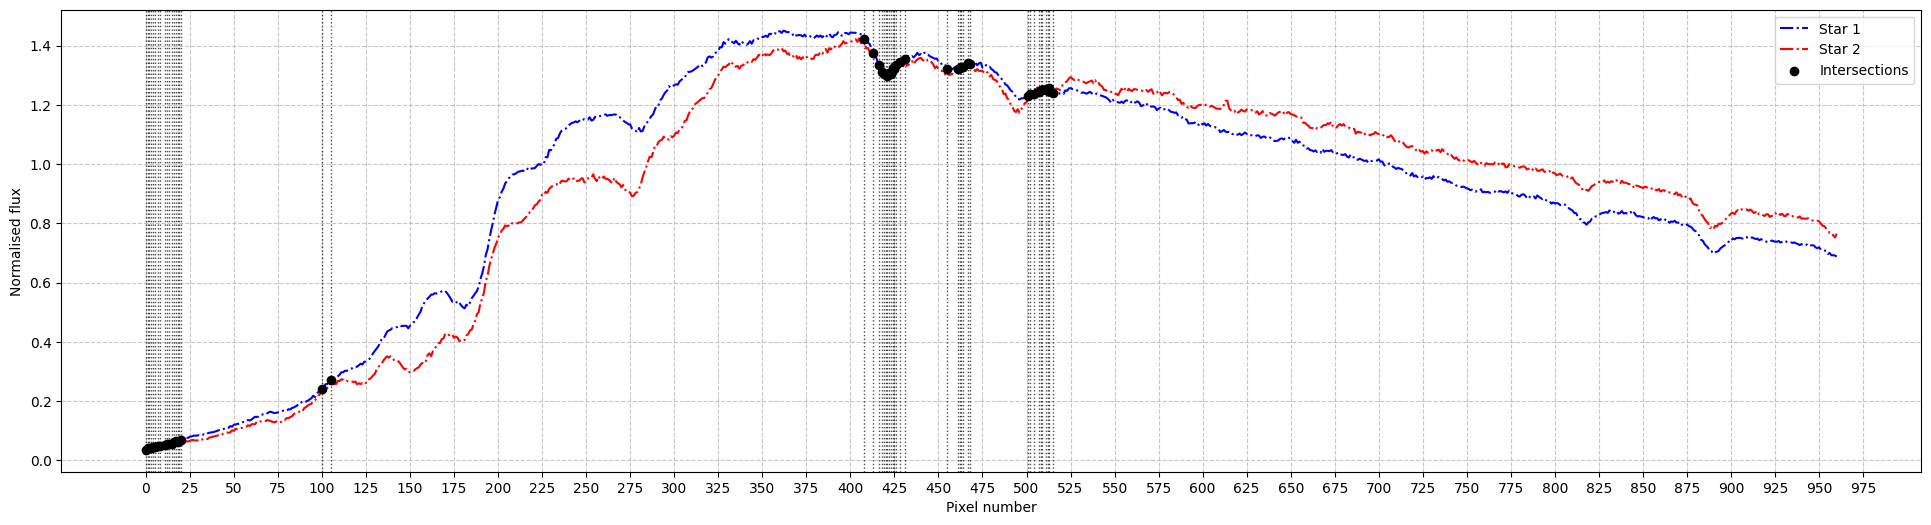

Intersections at pixel numbers: [  0   1   2   3   4   5   7   8  11  12  13  15  16  17  18  19  20 100
 105 408 413 416 418 419 420 421 422 423 424 425 426 428 431 455 461 462
 463 464 467 468 501 502 504 507 508 509 511 512 513 515]


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# arrays
flux1 = wc.normalise(star1[nframes//2])
flux2 = wc.normalise(star2[nframes//2])
x = np.arange(len(flux1))  # pixel numbers

# find the difference between the two
diff = flux1 - flux2

# find where the sign of the difference changes
intersections = np.where(np.diff(np.sign(diff)))[0]

intersections= np.where(np.abs(diff)<=0.01)[0]
print(np.size(intersections))

# show plot with intersection points
plt.figure(figsize=(24, 6))
plt.plot(x, flux1, 'b-.', label='Star 1')
plt.plot(x, flux2, 'r-.', label='Star 2')
plt.scatter(intersections, flux1[intersections], color='k', label='Intersections', zorder=5)
for xi in intersections:
    plt.axvline(x=xi, color='black', linestyle=':', alpha=0.7, linewidth=1)
plt.xlabel('Pixel number')
plt.ylabel('Normalised flux')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, 1000, 25))  # ticks every 50 pixels from 0 to 1000
plt.savefig('spectra_intersections.png', dpi=300, bbox_inches='tight')
plt.show()

# Print the intersection points
print("Intersections at pixel numbers:", intersections)
common_lines = np.array(intersections)


# Method 1) fitting Moffat profiles to the absorption lines.

First try a fit to the line at y pixel ~ 620, using the Moffat functions in wavelength calibration.

In [150]:
help(wc.moffat_fit_lines)

Help on function moffat_fit_lines in module reduction_utils.wavelength_calibration:

moffat_fit_lines(flux, error, line_positions, wvl=None, tolerance=10, box_width=60, enforce_negative=False, verbose=False, return_nans=True)
    A function to fit Moffat profiles at a list of user-defined absorption line locations for a SINGLE stellar spectrum, not an ndarry of multiple spectra. For this use fit_all_moffat_profiles().
    
    Inputs:
    flux - the 1D stellar spectrum
    error - the error on the 1D stellar spectrum's fluxes
    line_positions - the list of guess locations for absorption lines to be fit. Note: if wanting to fit a single line, this must still be defined as a list but with length=1
    wvl - the wavelengths can be supplied in Angstroms if the wavelength solution has already been calculated. If working in pixel space, this can be left as None. Default=None
    tolerance - the maximum number of wavelength resolution elements at which to accept the solution's location, oth

In [29]:
# Make x array, which is just the pixels
pixels = np.arange(0,len(star1[nframes//2]))

# Define the test line, which needs to be a list as the function only operates on lists of lines
test = np.array([116.01895391,145.36225158,241.60580282,381.2794091,418.30160916,456.63680272,623.86898183,776.74949436,847.34333575,917.58609248])
a = [468,635,785,850]
test_line = [788.5]
test_line = [860]
test_line = [635]
test_line = [418.30160916]

# Fit the single line in the reference frame
wc.moffat_fit_lines(star1[nframes//2],error1[nframes//2],test_line,wvl=pixels
                    ,tolerance=10,box_width=30,enforce_negative=False,verbose=True,return_nans=True)


(array([nan]), array([], dtype=float64), array([], dtype=float64))

In [154]:
# Now I will just plot various lines I have found to see how much the dips are shifting by:

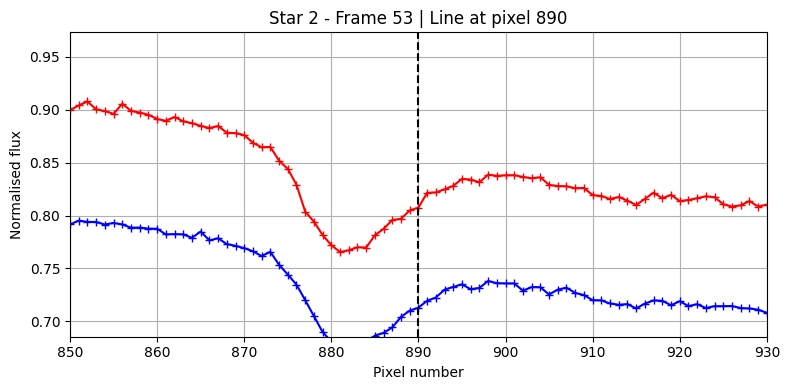

In [18]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time as time_func
import numpy as np
common_lines_2 = np.array([12,155,253,392])
common_lines_2 = np.array([155])
common_lines_2 = np.array([157,201,253,392])
common_lines_2 = np.array([201])
common_lines_2 = np.array([788,858])
common_lines_2 = np.array([468])
common_lines_2 = np.array([127.39403,200.7006,489.9322,697.5050])
common_lines_2 = np.array([116.01895391,145.36225158,241.60580282,381.2794091,456.63680272,623.86898183,776.74949436,847.34333575,917.58609248])
common_lines_2 = np.array([52,99,125,154,162.5,252,310,391,465,488,632,786,858,927])
common_lines_2 = np.array([180,280,420,495,820,890])
common_lines_2 = np.array([219,316.5,459,534,855,928])
common_lines_2 = np.array([180,280,420,457,495,817,890])
window_half_width = 30  # adjust this to zoom in more/less
ymin, ymax = 0.8, 1.1   # adjust based on expected normalised depth

for line_pixel in common_lines_2:
    for i in range(len(star2)):
        spectrum = wc.normalise(star2[i])
        
        # Define x range around the line
        x_min = int(max(line_pixel - window_half_width, 0))
        x_max = int(min(line_pixel + window_half_width, len(spectrum)))
        x_vals = np.arange(x_min, x_max)    

        y_vals = spectrum[x_min:x_max]
         
        ymin = np.nanmin(y_vals) - 0.08  # ptp = peak-to-peak = max - min ymax = np.max(y_vals) + 0.05 * np.ptp(y_vals)
        ymax = np.nanmax(y_vals) + 0.08  # ptp = peak-to-peak = max - min ymax = np.max(y_vals) + 0.05 * np.ptp(y_vals)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(wc.normalise(star1[i]), 'b-+')
        plt.plot(wc.normalise(star2[i]), 'r-+')
        plt.axvline(x=line_pixel, color='black', linestyle='--', label='Line centre')
        plt.title(f'Star 2 - Frame {i+1} | Line at pixel {line_pixel}')
        plt.xlabel('Pixel number')
        plt.ylabel('Normalised flux')
        plt.xlim(x_min-10, x_max+10)

        try:
            plt.ylim(ymin, ymax)
        except:
            pass
        plt.grid(True)
        plt.tight_layout()
        display(plt.gcf())
        clear_output(wait=True)
        if i == nframes//2:
            time_func.sleep(2.5)
        else:
            time_func.sleep(0.01)
        plt.close()

In [65]:
# Same as above, but perhaps more clear

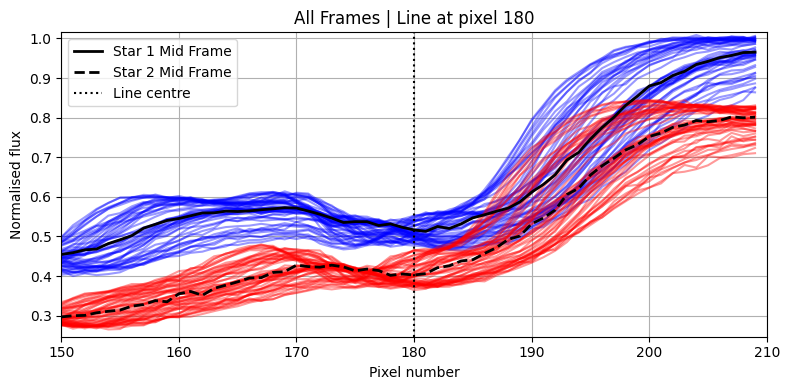

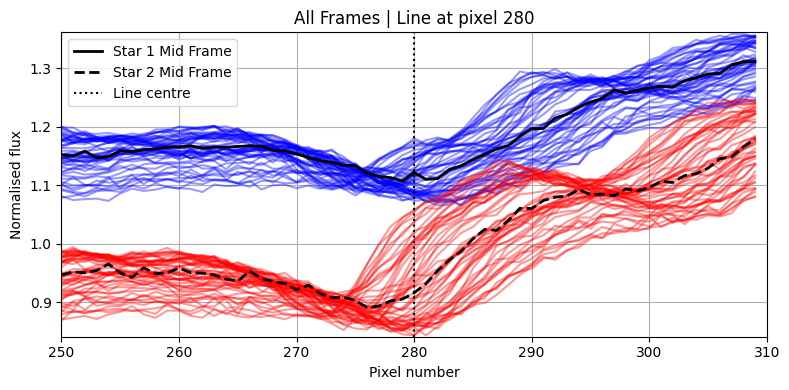

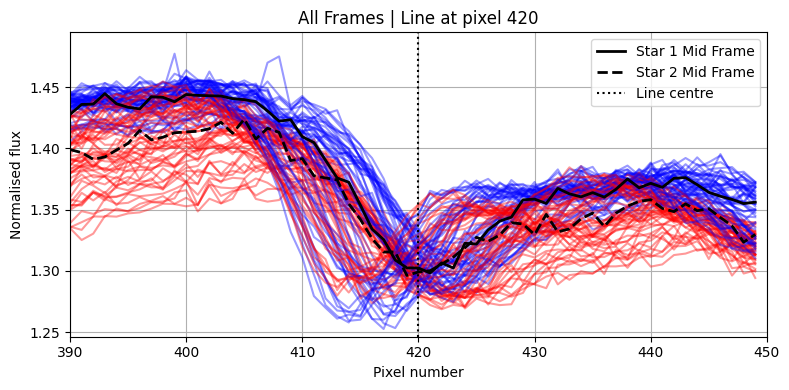

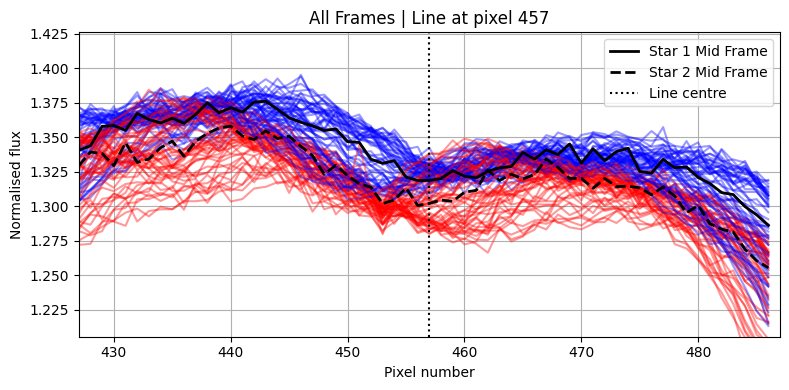

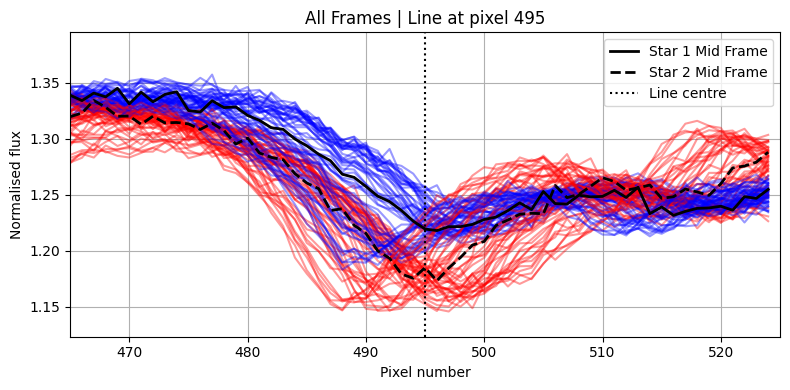

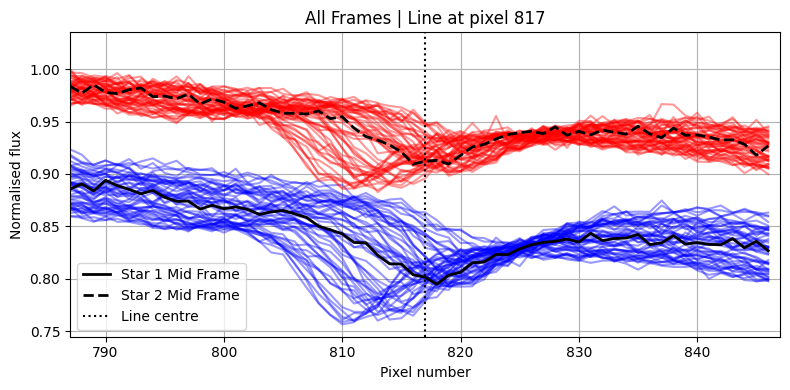

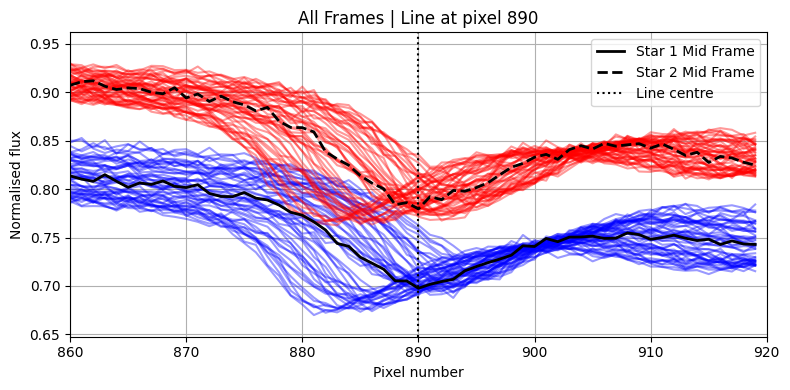

In [25]:
import matplotlib.pyplot as plt
import numpy as np

common_lines_2 = np.array([12, 155, 253, 392])
common_lines_2 = np.array([12,25,27,49,50,55,155,201,253,263,345,355,392])
common_lines_2 = np.array([157,201,253,392,788,858])
common_lines_2 = np.array([int(x) for x in [116.01895391, 145.36225158, 242.60580282, 
                                            381.2794091, 418.30160916, 456.63680272, 
                                            623.86898183, 776.74949436, 847.34333575, 
                                            917.58609248]])

common_lines_2 = np.array([127,155,164,252,310,391,466,488,634,786,857,927])
common_lines_2 = np.array([180,280,420,495,820,890])
common_lines_2 = np.array([219,316,459,534,855,928])
common_lines_2 = np.array([180,280,420,457,495,817,890])

window_half_width = 30
nframes = len(star1)

for line_pixel in common_lines_2:
    plt.figure(figsize=(8, 4))

    for i in range(nframes):
        spectrum1 = wc.normalise(star1[i])
        spectrum2 = wc.normalise(star2[i])

        x_min = max(line_pixel - window_half_width, 0)
        x_max = min(line_pixel + window_half_width, len(spectrum1))

        x_vals = np.arange(x_min, x_max)
        y_vals1 = spectrum1[x_min:x_max]
        y_vals2 = spectrum2[x_min:x_max]

        plt.plot(x_vals, y_vals1, 'b-', alpha=0.4)
        plt.plot(x_vals, y_vals2, 'r-', alpha=0.4)

    # Plot the middle frame on top in black
    mid_idx = nframes // 2
    spectrum1_mid = wc.normalise(star1[mid_idx])[x_min:x_max]
    spectrum2_mid = wc.normalise(star2[mid_idx])[x_min:x_max]

    plt.plot(x_vals, spectrum1_mid, 'k-', linewidth=2, label='Star 1 Mid Frame')
    plt.plot(x_vals, spectrum2_mid, 'k--', linewidth=2, label='Star 2 Mid Frame')

    plt.axvline(x=line_pixel, color='black', linestyle=':', label='Line centre')
    plt.title(f'All Frames | Line at pixel {line_pixel}')
    plt.xlabel('Pixel number')
    plt.ylabel('Normalised flux')
    plt.grid(True)
    plt.legend()

    try:
        ymin = min(np.nanmin(spectrum1_mid), np.nanmin(spectrum2_mid)) - 0.05
        ymax = max(np.nanmax(spectrum1_mid), np.nanmax(spectrum2_mid)) + 0.05
        plt.ylim(ymin, ymax)
    except:
        pass

    plt.xlim(x_min, x_max)
    plt.tight_layout()
    plt.show()

Now we run these fits to all lines as defined in 'common_lines'. However, some of these may result in poor fits when running wc.moffat_fit_lines, as in the cell below.

Therefore I iterate the below cell and define a new array 'common_lines_2' which only includes lines which are well fitted by the Moffat profile. I determine by-eye whether these seem to fit well or not. The blue dots in the below plots show the data, the orange line is the Moffat profile, the green line is the centre of the Moffat profile and the black line is the initial guess (as defined in common_lines). Looking at the difference between the black and green lines is the best indicator as to whether the Moffat profile has fitted the data well. 

Note that in this example I may have been over zealous in removing lines I thought to be poorly fit. However as long as you have at least 10 good lines covering the full wavelength range, this should be enough.

As we chose to return nan for unsuccessful fits, we need to remove these from the reference line array, via:

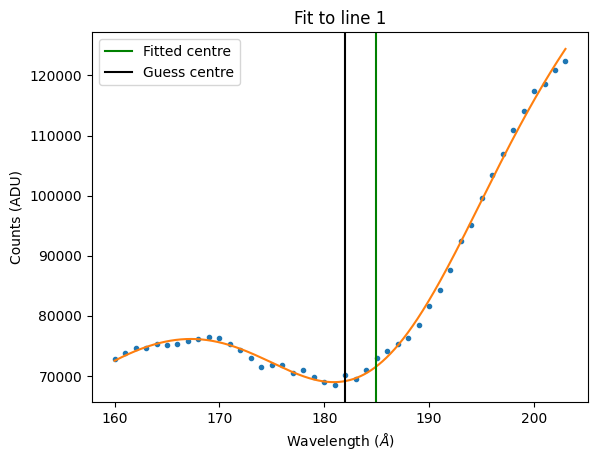

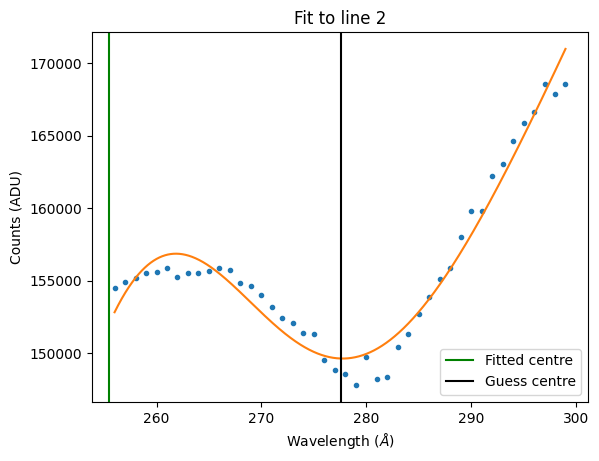

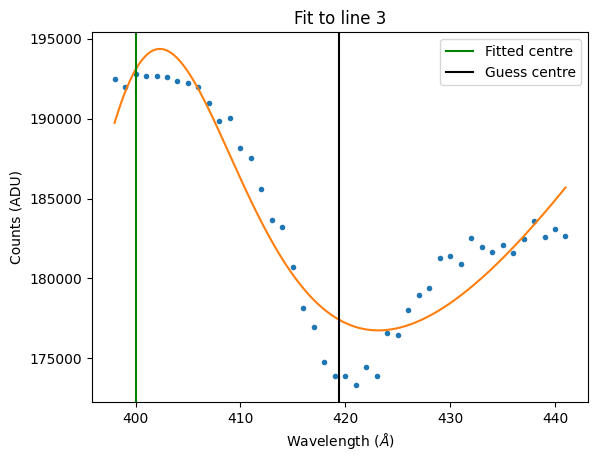

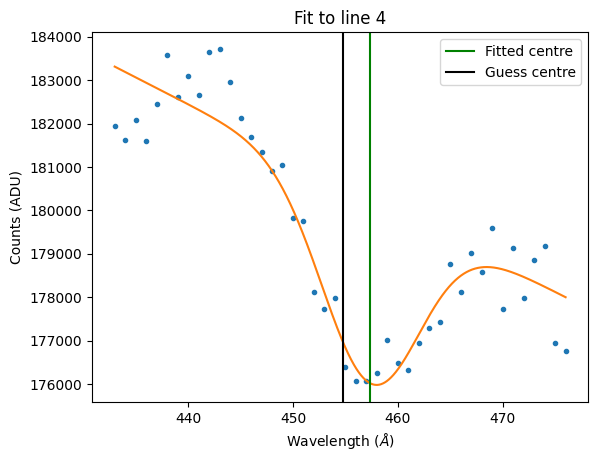

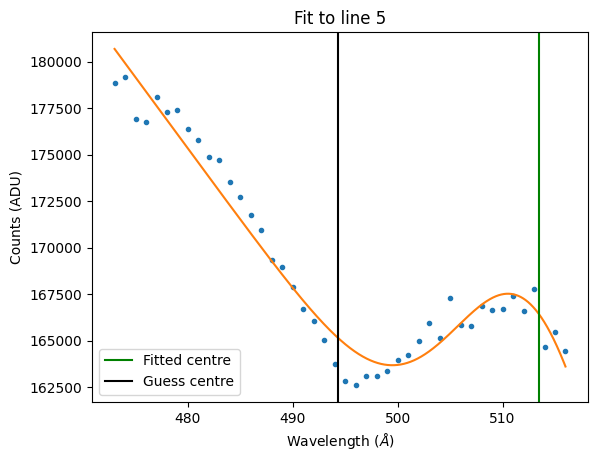

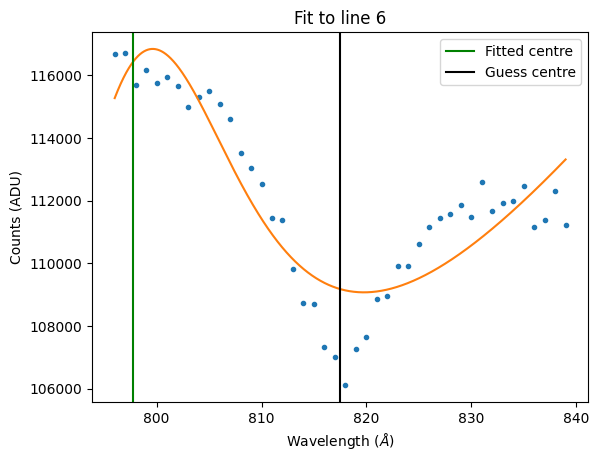

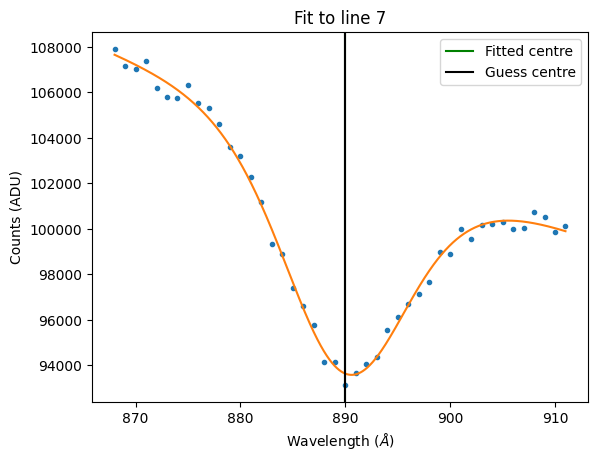

In [39]:
common_lines_2 = np.array([138,310,403,432,471,620,819,911,1003,1127,1394,1430,1537,1630])
common_lines_2 = np.array([157,201,253,392,785,850])
common_lines_2 = np.array([116.01895391,145.36225158,241.60580282,381.2794091,418.30160916,456.63680272,623.86898183,776.74949436,847.34333575,917.58609248])
common_lines_2 = np.array([116.01895391,145.36225158,241.60580282,381.2794091,456.63680272,623.86898183,776.74949436,847.34333575,917.58609248])
common_lines_2 = np.array([127,155,164,252,310,391,466,488,634,786,857,927])
common_lines_2 = np.array([492])
common_lines_2 = np.array([221,316.5,459,534,855,928])
common_lines_2 = np.array([180,277,422,457,495,817,890])
common_lines_2 = np.array([182,277.56158943,419.42758403,454.7843833,494.32885978,817.5,890])


box_width = 60
pixels = np.arange(0,len(star2[nframes//2]))

# A counter to track how many iterations of various parameters we've run
trial = 1

ref_lines,_,good_lines = wc.moffat_fit_lines(star1[nframes//2],error1[nframes//2],common_lines_2,wvl=pixels
                    ,tolerance=25,box_width=45,enforce_negative=False,verbose=True,return_nans=True)

In [38]:
print(ref_lines)
print(good_lines)

[182,280.84737336,420.02606798,457.37459745,495.46516144,817.38252924,889.79770762]

[187.91805438 280.84737336 420.02606798 457.37459745 495.46516144
 817.38252924 889.79770762]
[0 1 2 3 4 5 6]


[182,
 280.84737336,
 420.02606798,
 457.37459745,
 495.46516144,
 817.38252924,
 889.79770762]

In [167]:
reference_lines = ref_lines[np.isfinite(ref_lines)]

print(reference_lines)

[126.10645694 153.96085523 163.9084867  251.49486537 309.42220467
 390.69078089 465.78228121 487.78664485 633.17174909 786.08852913
 856.14538786 927.70446065]


Note: as we have opened a number of different interactive plots, it can be a good idea to periodically close these to save RAM. This is done via:

In [12]:
# plt.close('all')

Now, using these lines and the reference locations found above, we can fit Moffat profiles to the same absorption lines for each frame of the stellar spectra.

In [13]:
help(wc.fit_all_moffat_profiles)

Help on function fit_all_moffat_profiles in module reduction_utils.wavelength_calibration:

fit_all_moffat_profiles(flux_array, error_array, ref_lines, wvl_array=None, tolerance=10, box_width=60, enforce_negative=False, verbose=False, return_nans=True)
    A function to fit Moffat profiles to the ndarray of all 1D spectra, by looping through each and running moffat_fit_lines().
    
    Inputs:
    flux_array - the ndarray of 1D spectra
    error_array - the ndarry of errors in the 1D spectra
    ref_lines - the list of absorption line locations as found in the fitted reference spectrum
    wvl_array - the wavelengths can be supplied in Angstroms if the wavelength solution has already been calculated. If working in pixel space, this can be left as None. Default=None
    tolerance - the maximum number of wavelength resolution elements at which to accept the solution's location, otherwise reject. For example, if set to 10 and the Moffat returns a mean > 10 pixels away from the inputted l

In [402]:
star1_moffat_line_shifts = wc.fit_all_moffat_profiles(star1,error1,reference_lines,tolerance=15,\
                                                      box_width=25,return_nans=True)


Now plot these measured shifts for each line.

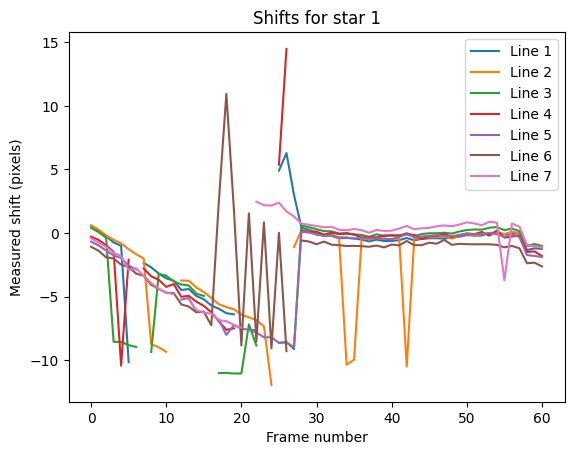

In [404]:
nlines = len(reference_lines)

plt.figure()
for i in range(nlines):
    plt.plot(star1_moffat_line_shifts[:, i], label=f'Line {i+1}')

plt.xlabel('Frame number')
plt.ylabel('Measured shift (pixels)')
plt.title('Shifts for star 1')
plt.legend()  # This adds the legend
plt.show()

As can be seen above, some lines are missing values - these are the returned nans, which preserve the shape of the arrays. Some lines have many nans and so we want to remove these as they would add unneccessary uncertainty in the final fits. 

First, however, we want to remove lines which appear as outliers. In this case, there are no obvious outliers (all lines have similar amplitude shifts and follow the same overall trends). For that reason, we will set a large sigma clip, which will preserve these lines.



In [84]:

star1_moffat_line_shifts_clipped = wc.clip_shift_outliers(star1_moffat_line_shifts,clip_level=5)


And plot these to make sure we haven't removed anything. 

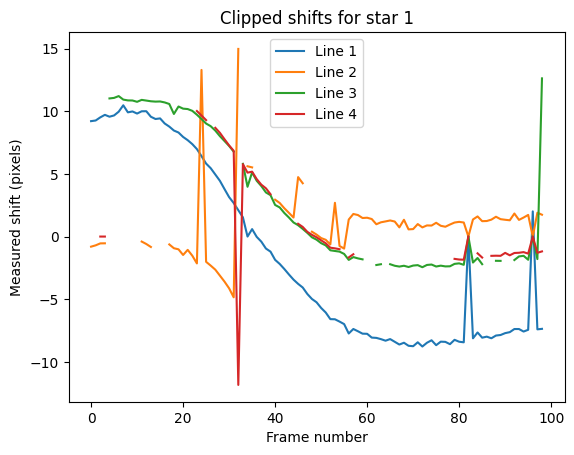

In [86]:
plt.figure()
for i in range(nlines):
    plt.plot(star1_moffat_line_shifts_clipped[:, i], label=f'Line {i+1}')
        
plt.xlabel('Frame number')
plt.ylabel('Measured shift (pixels)')
plt.title('Clipped shifts for star 1')
plt.legend()
plt.show()


Good, this looks the same.

Now, we need to use these measured shifts to relate how each spectrum's x axis (pixel number) relates to the reference image. Using this relation we can then resample (interpolate) each spectrum onto the same x axis as the reference spectrum.

We could do this using the measured shifts as plotted above. However, and as I have found empirically, this leads to increased noise in the resulting light curves. Instead, we want to 'smooth' these shifts for each line. To do this, we either fit a polynomial, or use the running median, for each line (reference_line[0], reference_line[1]...). This leverages information for the shifts of each line across the whole night's observations as, in most cases, the shifts should be fairly smoothly varying (and not as spikey as in the above plot). This spikiness is more often associated with the uncertainty in the measured position than real short-term variability in each absorption line's location.

To smooth these shifts, we do the below using wc.resample_smoothly(). This is an iterative process where we amend each parameter parsed to this function and record the resulting noise in the white light and spectroscopic light curves. We then choose the parameters that resulted in the lowest noise in the light curves.


In [59]:
help(wc.resample_smoothly)

Help on function resample_smoothly in module reduction_utils.wavelength_calibration:

resample_smoothly(reference_pixel_locations, measured_shifts, input_arrays, sigma_clip_outliers=3, median=False, poly_order=3, mf_box_width=None, min_good=0.9, spline_smoothing_factor=None, verbose=False, refit_polynomial=None, reference_wvl_array=None, use_pysynphot=False)
    Use this function to resample spectra, following a spline smoothing to the measured shifts from cross-correlation/Gaussian fitting.
    
    This is recommended to reduce the noise in the resulting light curves.
    
    Input:
    reference_pixel_locations - the pixel positions of the absorption features in the reference spectrum. As found through Gaussian fitting or defined for the cross-correlation.
    measured_shifts - the measured shifts between each spectrum and the reference spectrum, as obtained through fts.
    input_arrays - dictionary of arrays of to be resampled. Typically {flux,error,xposition,sky}
    sigma_clip_

First define the parameter values for resample_smoothly():

A note on min_good: This is the fraction of measured line shifts which must not be nans for each line in order for it to be included. In the star1_moffat_line_shifts_clipped array above, some of these line shifts contain many values which are np.nan. If these lines are included they could increase the noise in the resulting resampling. min_good ignores any line which has a fraction of measured line shifts which is less than min_good. 

e.g. if the measured shifts for one line (in pixels) are [0.8,1.5,2.6,np.nan,np.nan,np.nan], then setting min_good > 0.5 will ignore this line as 50% of the measured shifts = np.nan. Typically I avoid setting min_good below 0.6.

In [87]:
# clip outliers laying more than this number of standard deviations from the polynomial. If using a median, this clip is performed in absolute pixel shifts.
sigma_clip_outliers = 3 

# set to True to use running median, False uses a polynomial, which is the default
median_filter = False 

# the order of the polynomial used for the pixel solution for each frame, where x = the reference pixel locations
# and y = the measured pixel locations for each frame. Iterate between 1 and 4.
poly_order = 1 

# the number of data points over which the median filter is calculated. Leave as None if median=False
median_filter_box_width = None 

# iterate between 0.6 and 0.9 in steps of 0.1
min_good = 0.9 

# If using a median, this sets the spline smoothing factor ('s' parameter in scipy's UnivariateSpline) of the spline used to fit the running median.
# This is necessary as sometimes the running median is still not smooth enough and needs further smoothing. The smaller the number
# the more likely the spline will run through all points. Try to keep this >~5.
spline_smoothing_factor = None 

# Define whether we want to plot the pixel solution for the first and last frame. 
show_plots = True

# Define whether we want to refit the polynomial after the initial fit. This allows us to clip outliers from the first fit.
# The value given to refit_polynomial is an integer and is interpreted as the number of standard deviations away from the residuals that should be clipped.
refit_polynomial = None


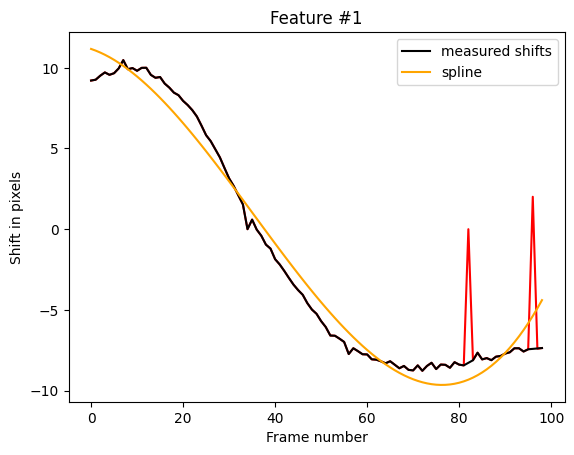

# lines used = 1
PIXEL SOLUTION PLOT FOR FRAME 0


/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/wavelength_calibration.py:866: RankWarning: Polyfit may be poorly conditioned
  pixel_solution_refitted = polyfit_shifts(reference_pixel_locations[good_lines],smooth_shifts[i],npixels,poly_order=poly_order,verbose=v,refit_polynomial=refit_polynomial)


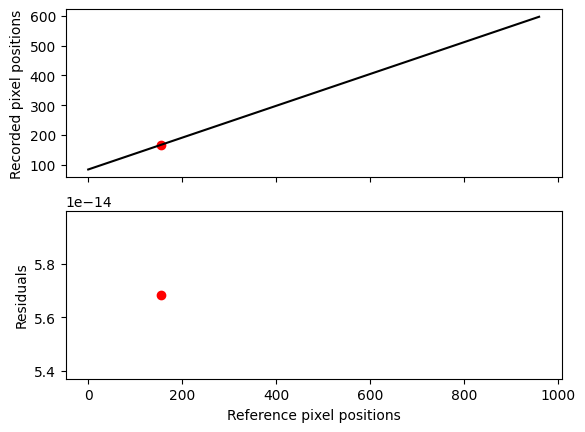

PIXEL SOLUTION PLOT FOR FRAME 98


/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/wavelength_calibration.py:866: RankWarning: Polyfit may be poorly conditioned
  pixel_solution_refitted = polyfit_shifts(reference_pixel_locations[good_lines],smooth_shifts[i],npixels,poly_order=poly_order,verbose=v,refit_polynomial=refit_polynomial)
/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/wavelength_calibration.py:866: RankWarning: Polyfit may be poorly conditioned
  pixel_solution_refitted = polyfit_shifts(reference_pixel_locations[good_lines],smooth_shifts[i],npixels,poly_order=poly_order,verbose=v,refit_polynomial=refit_polynomial)
/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/wavelength_calibration.py:866: RankWarning: Polyfit may be poorly conditioned
  pixel_solution_refitted = polyfit_shifts(reference_pixel_locations[good_lines],smooth_shifts[i],npixels,poly_order=poly_order,verbose=v,refit_polynomial=refit_polynomial)
/Users/u2257755/Documents/Tiberius/Tiberius/src/reducti

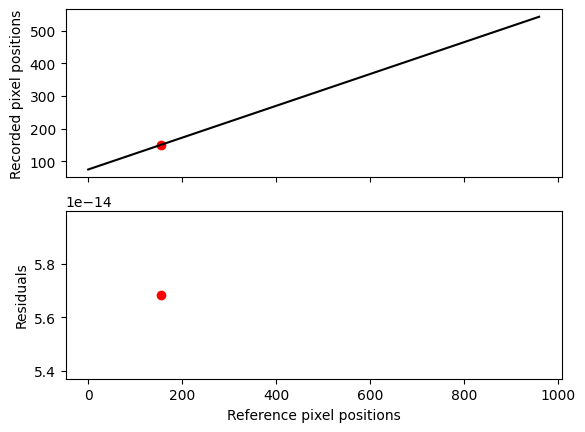

In [88]:

# Close all open plots for each iteration - uncomment this
# plt.close('all')

# Define the dictionary of inputs for star 1 that we want to be resampled
input1 = {'flux':star1,'error':error1,'xposition':xpos1,'sky':sky1}




resampled_star1,n_lines_used_1,smooth_shifts_1,lines_used_1 = \
wc.resample_smoothly(reference_lines,star1_moffat_line_shifts_clipped,input1,\
                                       sigma_clip_outliers,median_filter,\
                                       poly_order,median_filter_box_width,\
                                       min_good,spline_smoothing_factor,
                                       show_plots,refit_polynomial)



In the above plots, each figure shows the measured line shifts for each reference absorption line in black, with measured shifts that are ignored by the sigma cut in red. The polynomial/median smoothed function is shown in orange for each line. In this case, the parameters look to have done a good job at capturing the smoothly varying changes in position of the lines. 

***Note: the code also prints out and returns'# lines used = N', which is the number of lines remaining following the min_good clip. This is a helpful indicator to see how many lines were used in the final resampling. We typically want this to be >~ 10.***


The bottom plots show the 'pixel solutions' for the first and last frame.


Now we want to do the same thing for star 2, using the same reference lines. We're using the same reference lines as we also want to interpolate star 2 onto the same x-axis as star 1's reference image. Therefore we need to relate the locations of the absorption lines in star 2 to the reference locations in star 1.

First we calculate the shifts:

In [93]:
star2_moffat_line_shifts = wc.fit_all_moffat_profiles(star2,error2,reference_lines,tolerance=10,\
                                                      box_width=60,return_nans=True)



Now plot the output:

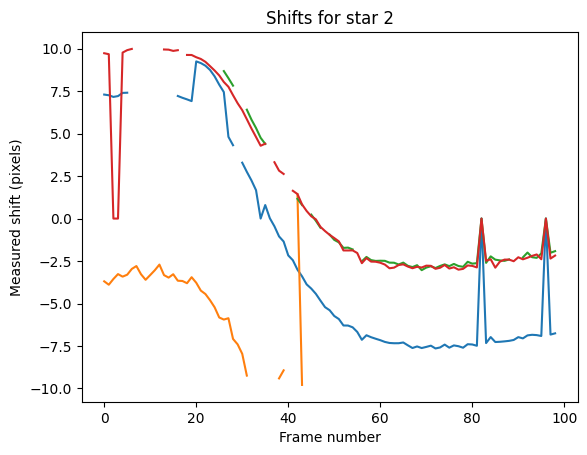

In [94]:
nlines = len(reference_lines)

plt.figure()
for i in range(nlines):
    plt.plot(star2_moffat_line_shifts[:,i])
plt.xlabel('Frame number')
plt.ylabel('Measured shift (pixels)')
plt.title('Shifts for star 2')
plt.show()


And clips these shifts, again using a broad clip as there are no obvious outliers.

In [95]:
star2_moffat_line_shifts_clipped = wc.clip_shift_outliers(star2_moffat_line_shifts,clip_level=5)


And check these clipped shifts:

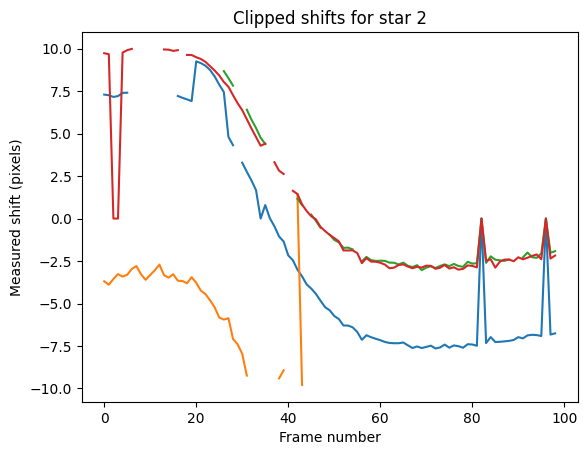

In [96]:

plt.figure()
for i in range(nlines):
    plt.plot(star2_moffat_line_shifts_clipped[:,i])
        
plt.xlabel('Frame number')
plt.ylabel('Measured shift (pixels)')
plt.title('Clipped shifts for star 2')
plt.show()



Again, these shifts have been preserved.

Now resample them smoothly, using the same parameters as for star 1 - this is important.

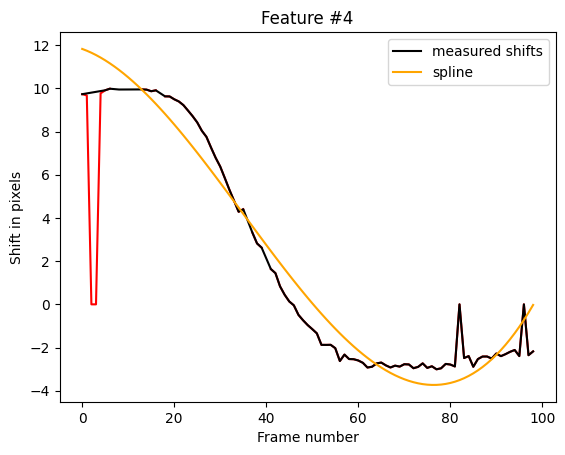

# lines used = 1
PIXEL SOLUTION PLOT FOR FRAME 0


/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/wavelength_calibration.py:866: RankWarning: Polyfit may be poorly conditioned
  pixel_solution_refitted = polyfit_shifts(reference_pixel_locations[good_lines],smooth_shifts[i],npixels,poly_order=poly_order,verbose=v,refit_polynomial=refit_polynomial)


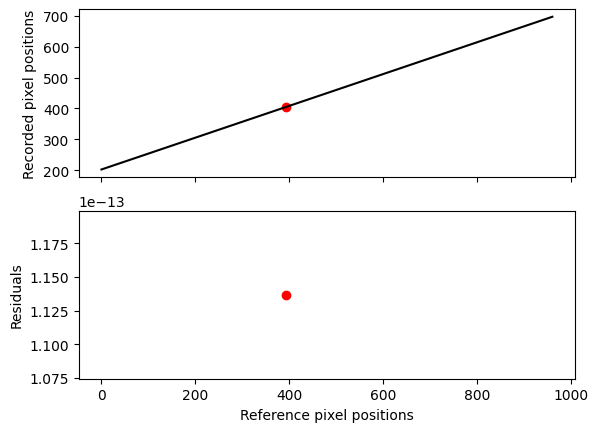

PIXEL SOLUTION PLOT FOR FRAME 98


/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/wavelength_calibration.py:866: RankWarning: Polyfit may be poorly conditioned
  pixel_solution_refitted = polyfit_shifts(reference_pixel_locations[good_lines],smooth_shifts[i],npixels,poly_order=poly_order,verbose=v,refit_polynomial=refit_polynomial)
/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/wavelength_calibration.py:866: RankWarning: Polyfit may be poorly conditioned
  pixel_solution_refitted = polyfit_shifts(reference_pixel_locations[good_lines],smooth_shifts[i],npixels,poly_order=poly_order,verbose=v,refit_polynomial=refit_polynomial)
/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/wavelength_calibration.py:866: RankWarning: Polyfit may be poorly conditioned
  pixel_solution_refitted = polyfit_shifts(reference_pixel_locations[good_lines],smooth_shifts[i],npixels,poly_order=poly_order,verbose=v,refit_polynomial=refit_polynomial)
/Users/u2257755/Documents/Tiberius/Tiberius/src/reducti

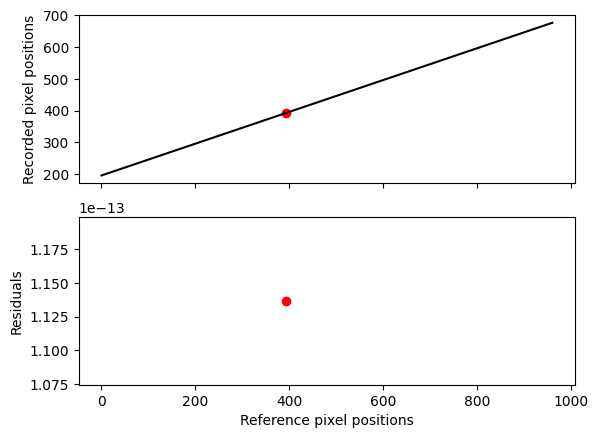

In [97]:
# Close all open plots for each iteration - uncomment this
# plt.close('all')

# Define the dictionary of inputs for star 2 that we want to be resampled
input2 = {'flux':star2,'error':error2,'xposition':xpos2,'sky':sky2}




resampled_star2,n_lines_used_2,smooth_shifts_2,lines_used_2 = \
wc.resample_smoothly(reference_lines,star2_moffat_line_shifts_clipped,input2,\
                                       sigma_clip_outliers,median_filter,\
                                       poly_order,median_filter_box_width,\
                                       min_good,spline_smoothing_factor,
                                       show_plots,refit_polynomial)




Now, plot the first and last frames for each star to see how well aligned they now are:

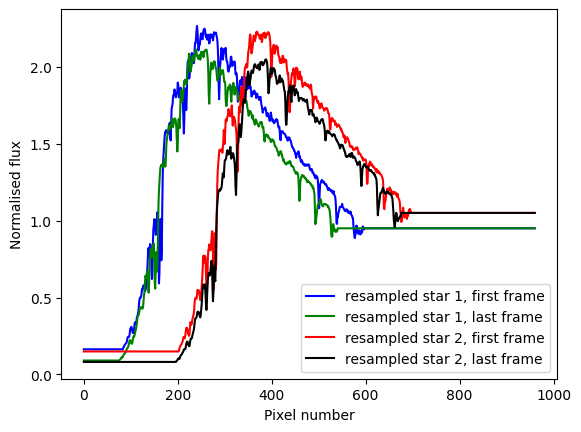

In [98]:

plt.figure()

plt.plot(0.95*wc.normalise(resampled_star1['flux'][0]),'b',label='resampled star 1, first frame')
plt.plot(0.95*wc.normalise(resampled_star1['flux'][-1]),'g',label='resampled star 1, last frame')

plt.plot(1.05*wc.normalise(resampled_star2['flux'][0]),'r',label='resampled star 2, first frame')
plt.plot(1.05*wc.normalise(resampled_star2['flux'][-1]),'k',label='resampled star 2, last frame')

plt.ylabel('Normalised flux')
plt.xlabel('Pixel number')
plt.legend(loc='lower right')
plt.show()



These are not perfectly aligned and this is a case where the resampling parameters can be improved above. Note that it is often difficult to get perfect alignment in the blue (pixels <= 250).

Now compare the light curves to see how well good the noise is in the resulting light curve.

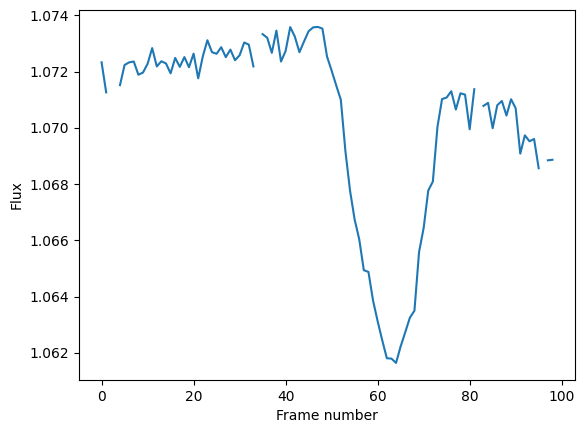

In [100]:
# Load in the original light curve, before resampling, for comparison
_,pre_f,pre_e = np.loadtxt(parent_direc+'white_light.dat',unpack=True)

# Plot the light curve in frames and record the locations of the first and fourth contact points of the transit
plt.figure()
plt.plot(pre_f)
plt.xlabel('Frame number')
plt.ylabel('Flux')
plt.show()

In [101]:
contact1 = 47
contact4 = 75

Now using these positions, we can normalise the light curve to the out of transit data.

In [102]:
no_resampling_flux = pre_f/np.median(pre_f[:contact1].tolist()+pre_f[contact4:].tolist())
no_resampling_error = (pre_e/pre_f) * no_resampling_flux


And calculate the white light curve for the resampled data

In [103]:
resampled_flux_smoothing = np.array(resampled_star1['flux']).sum(axis=1)/np.array(resampled_star2['flux']).sum(axis=1)
resampled_flux_smoothing = resampled_flux_smoothing/np.median(np.hstack((resampled_flux_smoothing[:contact1],resampled_flux_smoothing[contact4:])))

no_resampling_flux = pre_f/np.median(pre_f[:contact1].tolist()+pre_f[contact4:].tolist())
no_resampling_error = (pre_e/pre_f) * no_resampling_flux

Now calculate the ratio of the noise in the post-resampled to pre-resampled data and plot the comparison.

RMS: post-resampling/pre-resampling = nan 


/opt/anaconda3/envs/Tiberius_env/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/Tiberius_env/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/Tiberius_env/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


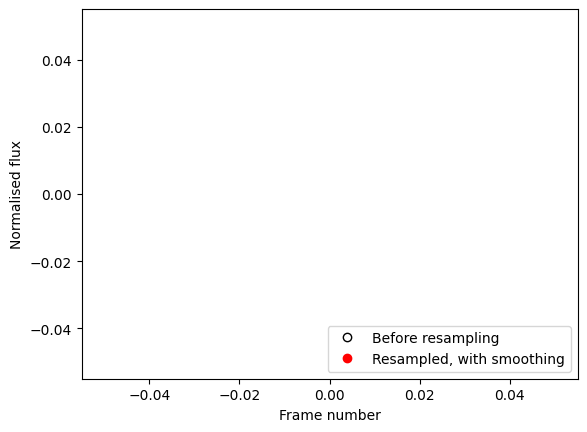

In [104]:
rms_post = np.std(resampled_flux_smoothing[contact4:])
rms_pre = np.std(no_resampling_flux[contact4:])

# Now define the ratio of the noise in the white light curves
rms_wl_ratio = rms_post/rms_pre

print("RMS: post-resampling/pre-resampling = %.2f "%(rms_wl_ratio))


plt.figure()
plt.plot(no_resampling_flux,'ko',markerfacecolor='None',label='Before resampling')
plt.plot(resampled_flux_smoothing,'ro',label='Resampled, with smoothing')
plt.ylabel('Normalised flux')
plt.xlabel('Frame number')
plt.legend(loc='lower right')
plt.show()


So in this case, the post-resampled data is actually noisier! We would then want to go back and change the resample_smoothy parameters to improve this.

We also want to check how the noise compares in the spectroscopic light curves. To do this we need to first construct these light curves by splitting up the spectra into different pixel regions.

The pixel scale of ACAM is 3.3A/pixel and we typically use wavelength bins around 250A wide.

In [32]:
# Define the pixel bins
pixel_bins = np.arange(0,len(star1[nframes//2]),250//3.3).astype(int)
nbins = len(pixel_bins)


Now split the spectra before and after resampling into the pixel bins, make light curves and compare the noise ratios as before.

In [33]:
# save the light curves that have worse noise
worse_noise = []

noise_ratio = []

for i in range(nbins-1):

    rf = resampled_star1['flux'][:,pixel_bins[i]:pixel_bins[i+1]].sum(axis=1)/resampled_star2['flux'][:,pixel_bins[i]:pixel_bins[i+1]].sum(axis=1)
    rf_norm = rf/np.median(rf[:contact1].tolist()+rf[contact4:].tolist())
    
    f = star1[:,pixel_bins[i]:pixel_bins[i+1]].sum(axis=1)/star2[:,pixel_bins[i]:pixel_bins[i+1]].sum(axis=1)
    f_norm = f/np.median(f[:contact1].tolist()+f[contact4:].tolist())

    if np.std(rf_norm[contact4:])/np.std(f_norm[contact4:]) > 1:
        worse_noise.append(i)
    
    noise_ratio.append(np.std(rf_norm[contact4:])/np.std(f_norm[contact4:]))
    
    print("Post/pre resampling = %.2f"%(np.std(rf_norm[contact4:])/np.std(f_norm[contact4:])))
    
print('\nFraction of bins that are worse = %.2f'%(len(worse_noise)/nbins))
print('Best noise ratio = %.2f; Worst noise ratio = %.2f; Median noise ratio = %.2f'%\
      (min(noise_ratio),max(noise_ratio),np.median(noise_ratio)))

Post/pre resampling = 1.10
Post/pre resampling = 1.05
Post/pre resampling = 1.22
Post/pre resampling = 1.16
Post/pre resampling = 1.04
Post/pre resampling = 1.17
Post/pre resampling = 1.03
Post/pre resampling = 0.99
Post/pre resampling = 1.05
Post/pre resampling = 1.01
Post/pre resampling = 1.01
Post/pre resampling = 1.07
Post/pre resampling = 0.99
Post/pre resampling = 0.96
Post/pre resampling = 0.73
Post/pre resampling = 0.93
Post/pre resampling = 0.91
Post/pre resampling = 1.01
Post/pre resampling = 1.01
Post/pre resampling = 0.99
Post/pre resampling = 0.99
Post/pre resampling = 1.01

Fraction of bins that are worse = 0.61
Best noise ratio = 0.73; Worst noise ratio = 1.22; Median noise ratio = 1.01


Ok, so we see that over half of the spectroscopic light curves are worse than before, again indicating we should test different parameters. 

To save the results, use a table like the following after printing the results for an easy copy/paste.

In [34]:
results = np.array([trial,box_width,tolerance,min_good,sigma_clip_outliers,median_filter,poly_order,\
                    median_filter_box_width,min_good,spline_smoothing_factor,refit_polynomial,\
                    n_lines_used_1,n_lines_used_2,np.round(rms_wl_ratio,2),np.round(len(worse_noise)/nbins,2),\
                    np.round(min(noise_ratio),2),np.round(max(noise_ratio),2),np.round(np.median(noise_ratio),2)])

In [35]:
separator = '|'
output = '|'+separator.join(results.astype(str))+'|'
print(output)

|1|60|10|0.9|3|False|1|None|0.9|None|None|11|9|1.06|0.61|0.73|1.22|1.01|


|Trial|box width|tolerance|min good|sigma clip outliers|median filter|poly order|median filter box width|min good|spline smoothing factor|refit polynomial|n lines used 1|n lines used 2|rms wl ratio|Fraction of bins that are worse|Min. noise ratio|Max. noise ration|Median noise ratio|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|1|60|10|0.9|3|False|1|None|0.9|None|None|11|9|1.06|0.61|0.73|1.22|1.01|



Now we'd do the above for many different iterations and choose the best one where the fraction of bins that are worse < 0.5 and the rms wl ratio < 1.0.

If happy with the output, then save the final resampled arrays. 

**Note: you will need to run all of the above with the final parameters to make sure resampled_star1 and resampled_star2 have been updated with the correct values.**

In [36]:
# pickle.dump(resampled_star1['flux'],open('../pickled_objects/improved_resampling/star1_flux_resampled.pickle','wb'))
# pickle.dump(resampled_star1['error'],open('../pickled_objects/improved_resampling/star1_error_resampled.pickle','wb'))
# pickle.dump(resampled_star1['xposition'],open('../pickled_objects/improved_resampling/xpos1_resampled.pickle','wb'))
# pickle.dump(resampled_star1['sky'],open('../pickled_objects/improved_resampling/sky1_resampled.pickle','wb'))


# pickle.dump(resampled_star2['flux'],open('../pickled_objects/improved_resampling/star2_flux_resampled.pickle','wb'))
# pickle.dump(resampled_star2['error'],open('../pickled_objects/improved_resampling/star2_error_resampled.pickle','wb'))
# pickle.dump(resampled_star2['xposition'],open('../pickled_objects/improved_resampling/xpos2_resampled.pickle','wb'))
# pickle.dump(resampled_star2['sky'],open('../pickled_objects/improved_resampling/sky2_resampled.pickle','wb'))

# pickle.dump(ref_lines,open('../pickled_objects/improved_resampling/ref_lines.pickle','wb'))

And save the measured shifts and smoothed shifts to arrays for later use in fitting. These are the means of all measured lines shifts.

In [37]:
ypos1_smooth = np.nanmean(smooth_shifts_1,axis=1)
ypos1 = np.nanmean(star1_moffat_line_shifts_clipped,axis=1)

ypos2_smooth = np.nanmean(smooth_shifts_2,axis=1)
ypos2 = np.nanmean(star2_moffat_line_shifts_clipped,axis=1)

/Users/james/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


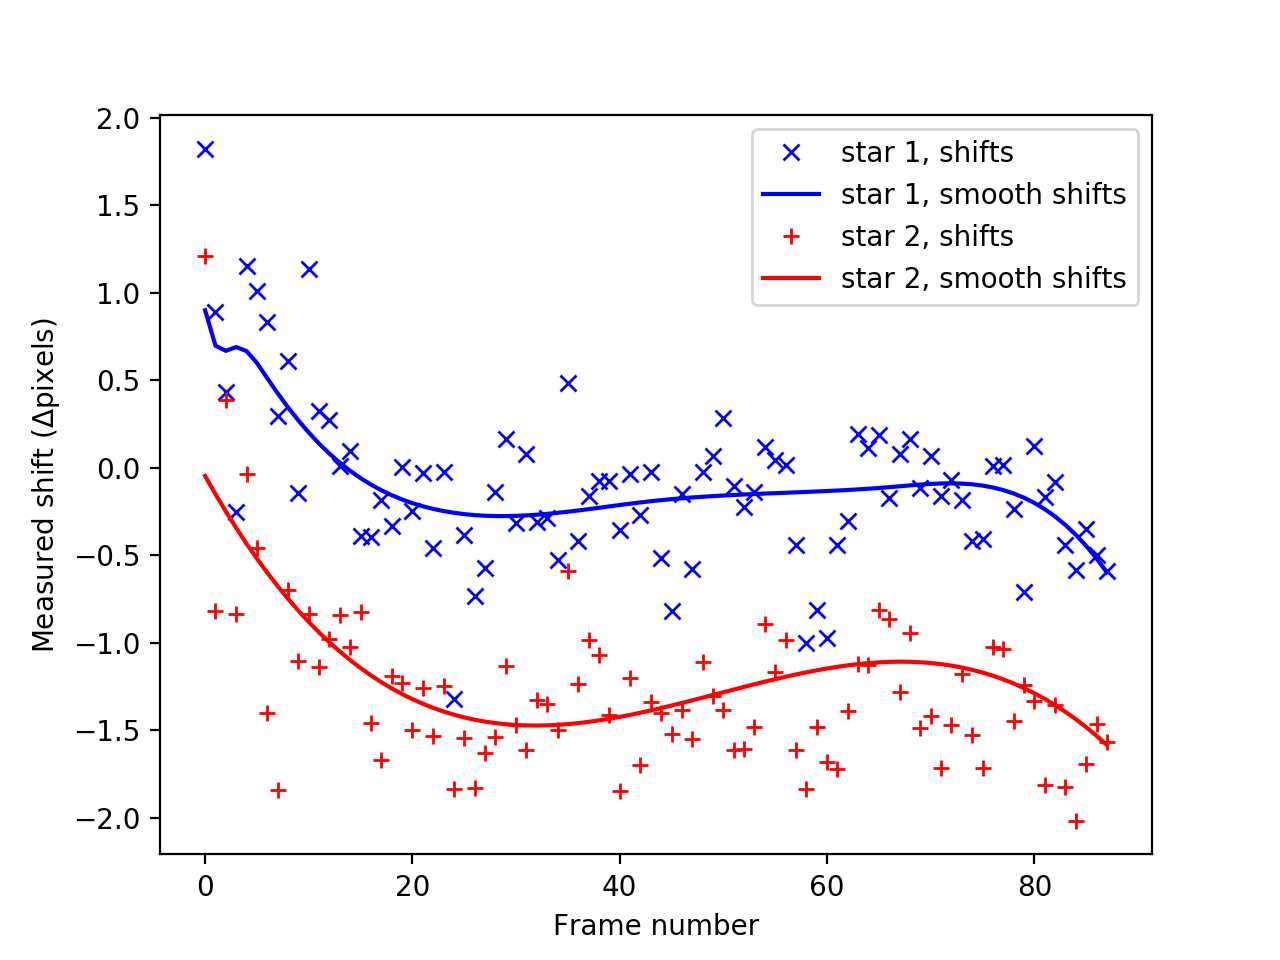

In [38]:
plt.figure()

plt.plot(ypos1,'bx',label='star 1, shifts')
plt.plot(ypos1_smooth,'b',label='star 1, smooth shifts')


plt.plot(ypos2,'r+',label='star 2, shifts')
plt.plot(ypos2_smooth,'r',label='star 2, smooth shifts')

plt.ylabel('Measured shift ($\Delta$pixels)')
plt.xlabel('Frame number')

plt.legend(loc='upper right')

plt.show()

And save the resulting arrays to pickled objects

In [39]:
# pickle.dump(ypos1,open('../pickled_objects/ypos1.pickle','wb'))
# pickle.dump(ypos1_smooth,open('../pickled_objects/ypos1.pickle','wb'))

# pickle.dump(ypos2,open('../pickled_objects/ypos2.pickle','wb'))
# pickle.dump(ypos2_smooth,open('../pickled_objects/ypos2_smooth.pickle','wb'))


# Method 2) using cross-correlation to find the line centres

This follows a similar process to the above method but differs in how we measure the shifts in the lines. Rather than fitting each absorption line with a Moffat profile, we cross-correlate the spectra. This essentially slides the spectra across one another and measures the similarity between the two spectra, as a function of the displacement of the spectra. 

For lower S/N spectra, where the absorption lines are difficult to fit with profiles, this can be a better method.

We're going to use the same lines as used for the Moffat fits above for this example, but note that we have to use the integer values of these as we're going to be using these locations to slice the arrays.

In [16]:
help(wc.compute_all_shifts)

Help on function compute_all_shifts in module reduction_utils.wavelength_calibration:

compute_all_shifts(ref_frame, all_frames, all_errors, line_positions, search_width=10, poly_order=3, verbose=False, refit_polynomial=None, resample=True, ancillary_data=None)
    The function that computes the shifts in the spectra for all 1D spectra using the cross-correlation technique.
    
    Inputs:
    ref_frame - the reference frame which all other spectra are compared with
    all_frames - the ndarray of all 1D spectra (including the reference frame itself)
    all_errors - the ndarray of errors on all 1D spectra (including the reference frame itself)
    line_positions - the list of absorption lines which are used to determine the shifts
    search_width - the seach width (in x data points) around each absorption line to consider. This clips out this many data points and performs the cross correlation for this region. Default=10
    poly_order - the order of the polynomial used for the pixe

In this case, we are again going to resample smoothly. Therefore we're only interested in np.array(all_shifts) as returned by compute_all_shifts() - we are going to re-do the resampling.

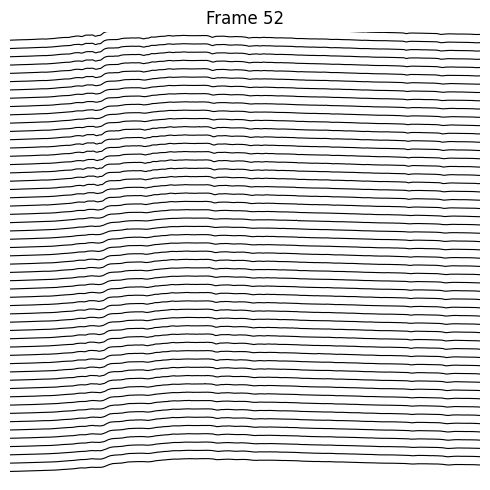

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import time as time_func

offset = 0.9
nframes = star1.shape[0]
length = star1.shape[1]

plt.figure(figsize=(5, 5))

for i in range(nframes):
    y = wc.normalise(star1[i])
    x = np.arange(length)
    
    plt.plot(x, y + i * offset, color='black', linewidth=0.8)
    plt.ylim(-offset, nframes * offset)
    plt.xlim(0, length)
    plt.gca().set_facecolor('white')
    plt.axis('off')
    plt.title(f'Frame {i}', fontsize=12, color='black')
    plt.tight_layout()
    
    display(plt.gcf())
    clear_output(wait=True)
    time_func.sleep(0.005)

plt.show()

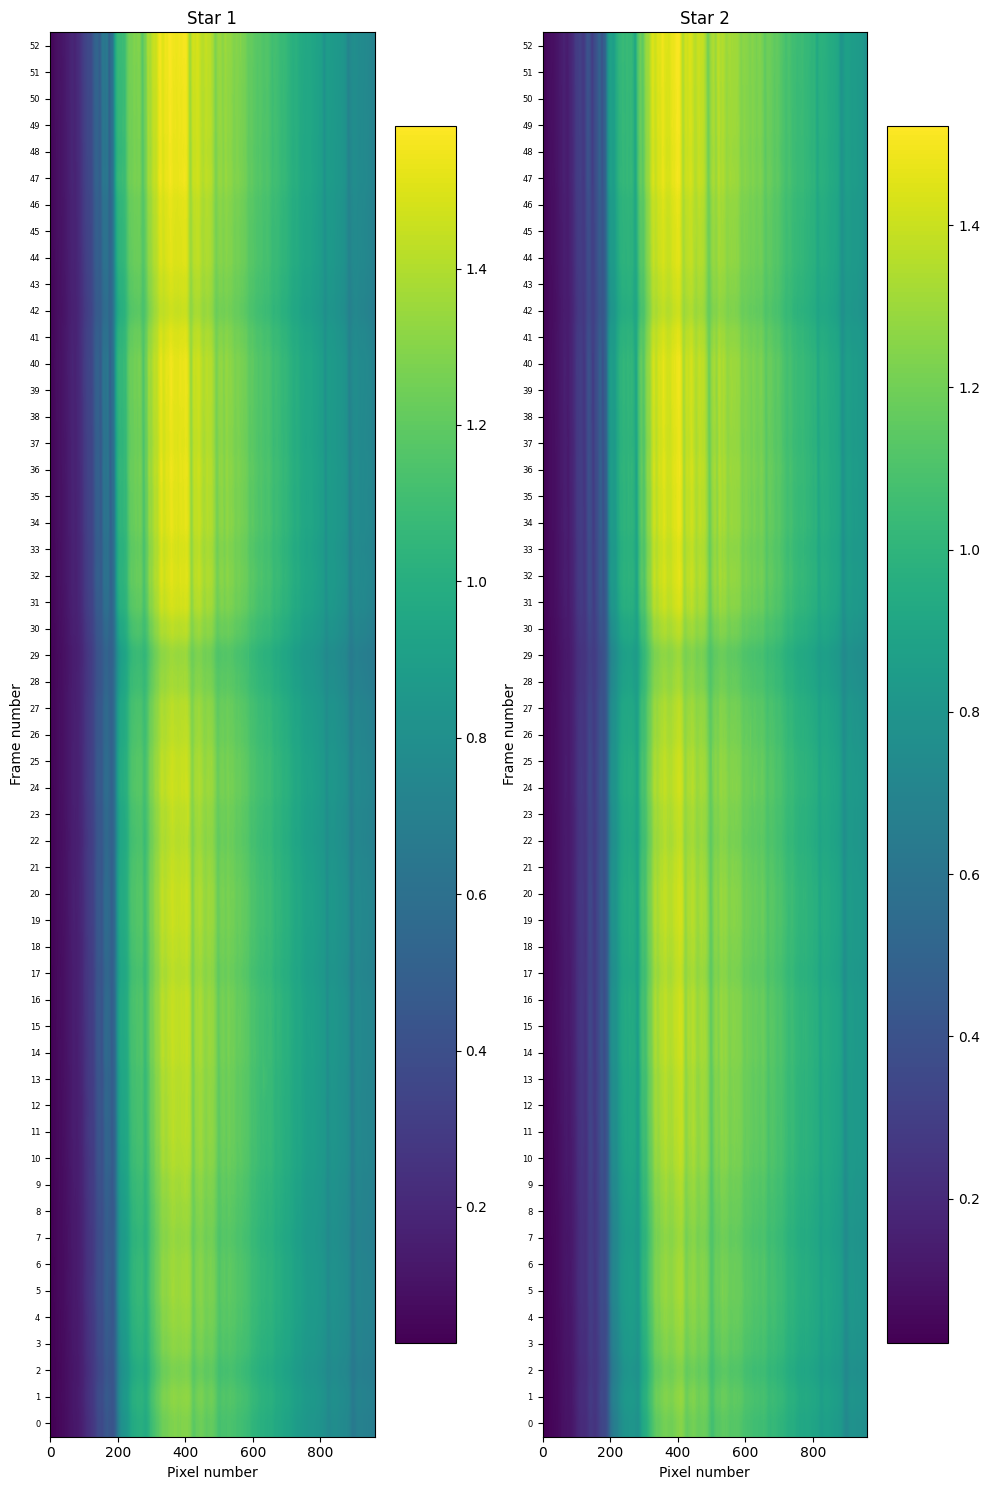

In [18]:
import matplotlib.pyplot as plt
import numpy as np

nframes = len(star1)

fig, axs = plt.subplots(1, 2, figsize=(10, 15), sharey=False)  # Make figure taller, remove sharey

# Plot star1
im1 = axs[0].imshow(wc.normalise(star1), aspect='auto', origin='lower')
axs[0].set_title('Star 1')
axs[0].set_xlabel('Pixel number')
axs[0].set_ylabel('Frame number')
axs[0].set_yticks(np.arange(nframes))
axs[0].tick_params(axis='y', labelsize=6)
fig.colorbar(im1, ax=axs[0], orientation='vertical')

# Plot star2
im2 = axs[1].imshow(wc.normalise(star2), aspect='auto', origin='lower')
axs[1].set_title('Star 2')
axs[1].set_xlabel('Pixel number')
axs[1].set_ylabel('Frame number')  # Add ylabel explicitly
axs[1].set_yticks(np.arange(nframes))
axs[1].tick_params(axis='y', labelsize=6)
fig.colorbar(im2, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.show()


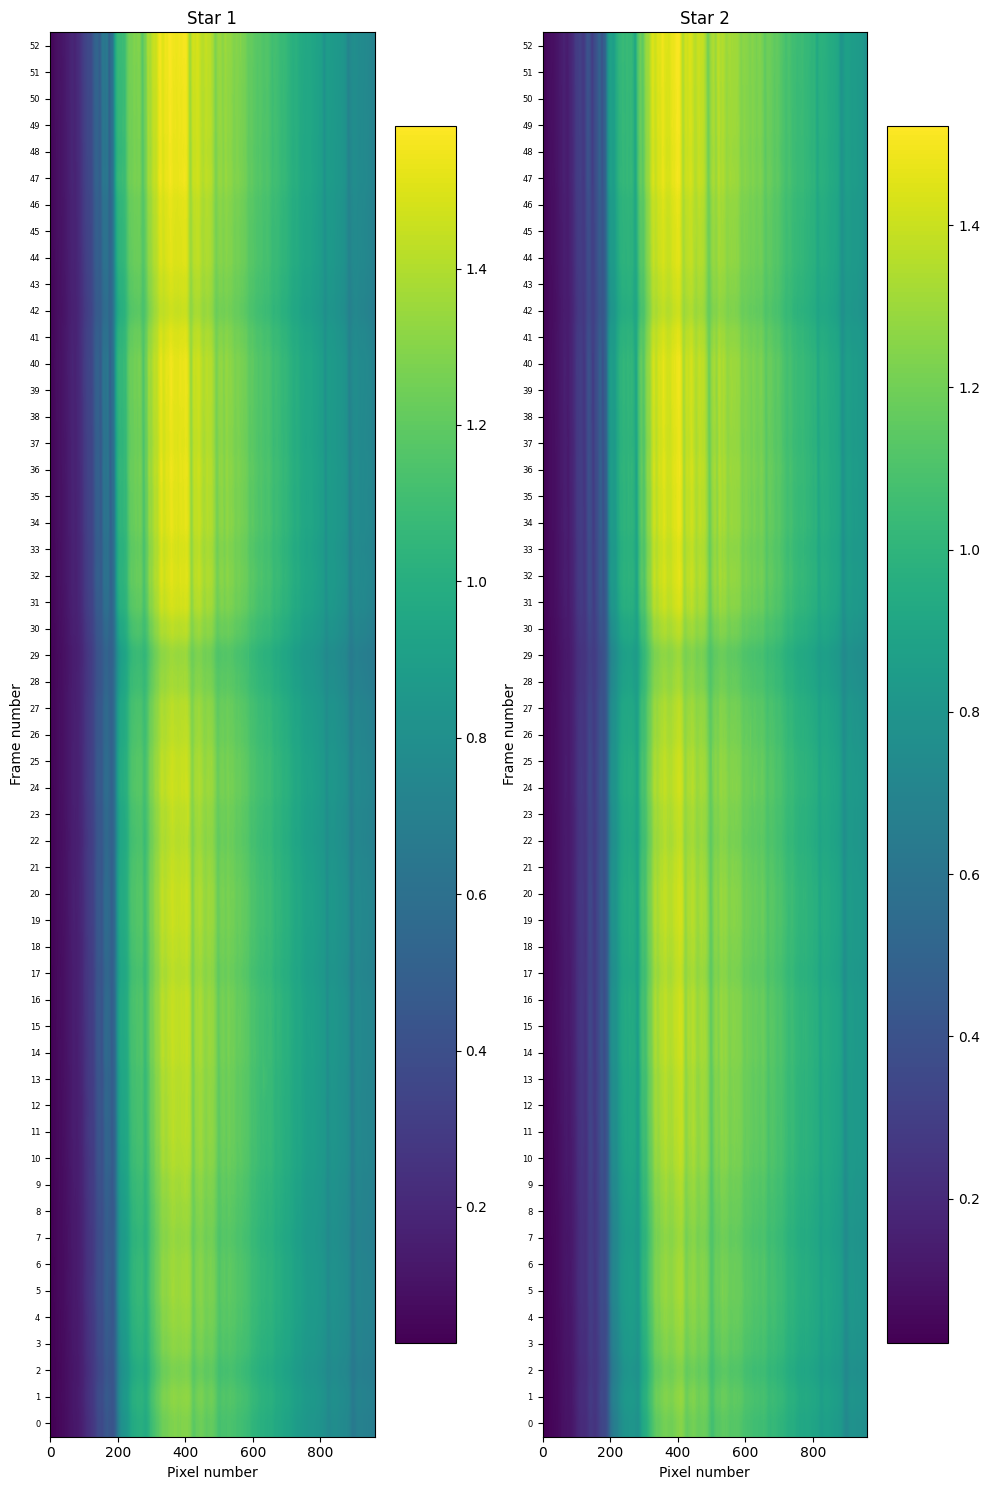

In [19]:
good_frames = np.setdiff1d(np.arange(star1.shape[0]), bad_frames)
star1_clean = star1[good_frames, :]
star2_clean = star2[good_frames, :]

import matplotlib.pyplot as plt
import numpy as np

nframes = len(star1)

fig, axs = plt.subplots(1, 2, figsize=(10,15), sharey=False)  # Make figure taller, remove sharey

# Plot star1
im1 = axs[0].imshow(wc.normalise(star1_clean), aspect='auto', origin='lower')
axs[0].set_title('Star 1')
axs[0].set_xlabel('Pixel number')
axs[0].set_ylabel('Frame number')
axs[0].set_yticks(np.arange(nframes))
axs[0].tick_params(axis='y', labelsize=6)
fig.colorbar(im1, ax=axs[0], orientation='vertical')

# Plot star2
im2 = axs[1].imshow(wc.normalise(star2_clean), aspect='auto', origin='lower')
axs[1].set_title('Star 2')
axs[1].set_xlabel('Pixel number')
axs[1].set_ylabel('Frame number')  # Add ylabel explicitly
axs[1].set_yticks(np.arange(nframes))
axs[1].tick_params(axis='y', labelsize=6)
fig.colorbar(im2, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.show()


In [20]:
star1_clean.shape

(53, 961)

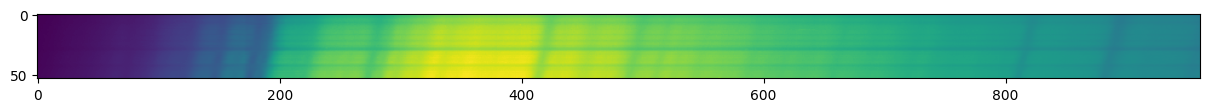

In [21]:
plt.figure(figsize=(15,5))
plt.imshow(star1_clean)

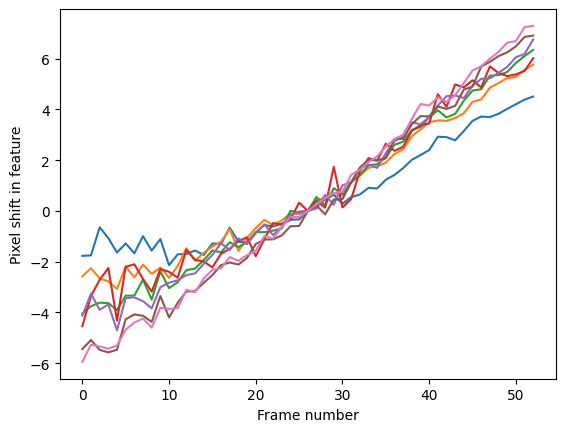

In [ ]:
import importlib
importlib.reload(wc)

poly_order = 3
reference_lines = np.array([155.54036637,253.03411637,392.57284192,468,635,785,850])
reference_lines = np.array([155.54036637,127.39403,253.03411637,392.57284192,468,489.9322,635.3012,788.5787,859.6218])
reference_lines = np.array([155.54036637,127.39403,253.03411637,392.57284192,468,635.3012,788.5787,859.6218])
reference_lines = np.array([116.01895391,145.36225158,241.60580282,381.2794091,418.30160916,456.63680272,623.86898183,776.74949436,847.34333575,917.58609248])
reference_lines = np.array([116.01895391,145.36225158,241.60580282,381.2794091,456.63680272,623.86898183,776.74949436,847.34333575,917.58609248])
reference_lines = np.array([153.96085523, 163.9084867 , 251.49486537, 309.42220467, 390.69078089, 465.78228121, 487.78664485, 633.17174909, 786.08852913, 856.14538786, 927.70446065])
reference_lines = np.array([153.96085523, 163.9084867 , 251.49486537, 390.69078089, 465.78228121, 487.78664485, 633.17174909, 786.08852913, 856.14538786, 927.70446065])
reference_lines = np.array([184.34802649,280.94296884,420.83976298,496.03986749,817.29385892,890.15977651])
reference_lines = np.array([180,280,420,457,495,817,890])
reference_lines = np.array([180,277.56158943,419.42758403,454.7843833,494.32885978,817.14832275,889.6262784])
# for line 1
reference_lines = np.array([182,280.84737336,420.02606798,457.37459745,495.46516144,817.38252924,889.79770762])


# Define search region for each absorption line in pixels
search_region = 25

_,_,star1_cc_line_shifts,_ = wc.compute_all_shifts(star1[nframes//2],star1_clean,error1_clean,\
                                                   np.round(reference_lines).astype(int),\
                                                   search_region,poly_order = 3,verbose = True,refit_polynomial=None)


We can also test these shifts to make sure they make sense and also check the pixel solution by doing the following:

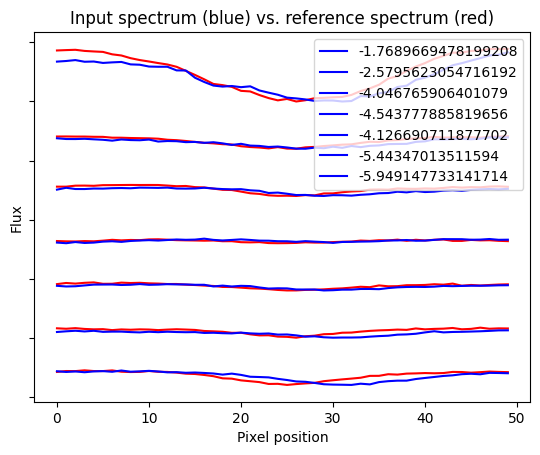

In [45]:
test_frame = star1_clean[0]
reference_spectrum = star1[nframes//2]

test_shifts = wc.compute_shifts(test_frame,reference_spectrum,np.round(reference_lines).astype(int),\
                                search_region,verbose=True)

The above plot shows all the reference lines with for the cut-out regions of the input spectrum (blue) and reference spectrum (red). The legend gives the measured difference in the locations (in pixels) of the 2 spectra recorded at each absorption line. 

Now plot the fit to these shifts (the pixel solution).

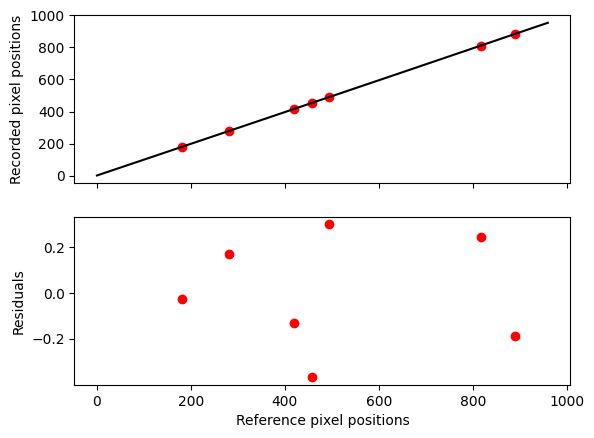

In [46]:
test_poly = wc.polyfit_shifts(np.round(reference_lines).astype(int),test_shifts,len(test_frame),\
                              2,True,refit_polynomial=None)

As before, we would now follow the process of clipping outlying shifts and resample_smoothly() and perform the same thing for star 2 as above but using the shifts measured by the cross-correlation and measured with respect to the same reference spectrum (i.e. a spectrum of star 1):

In [47]:
np.sum(np.isnan(star2_clean))

0

[180.         277.56158943 419.42758403 454.7843833  494.32885978
 817.14832275 889.6262784 ]


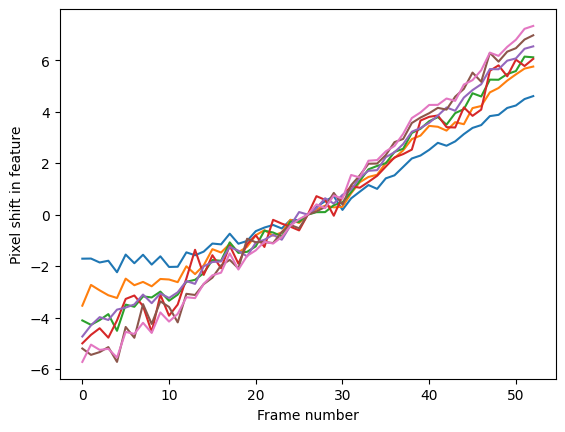

In [48]:
import importlib
importlib.reload(wc)

poly_order = 2
ref_lines = reference_lines
ref_lines = np.array([224.63084419,317.10748764,458.47427118,533.07395384,854.99359717,927.4991501])
ref_lines = np.array([180,277.56158943,419.42758403,454.7843833,494.32885978,817.14832275,889.6262784])


print(ref_lines)

# Define search region for each absorption line in pixels
search_region = 20

_,_,star2_cc_line_shifts,_ = wc.compute_all_shifts(star2[nframes//2],star2_clean,error2_clean,\
                                                   np.round(reference_lines).astype(int),\
                                                   search_region,poly_order = 3,verbose = True,refit_polynomial=None)

Now we can move on to notebook 4. - not quite

In [49]:
# Define the dictionary of inputs for star 1 that we want to be resampled
input1 = {'flux':star1_clean,'error':error1_clean,'xposition':xpos1_clean,'sky':sky1_clean}
input2 = {'flux':star2_clean,'error':error2_clean,'xposition':xpos2_clean,'sky':sky2_clean}


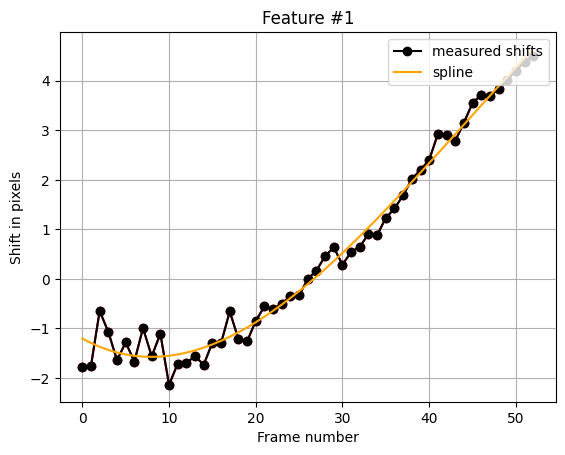

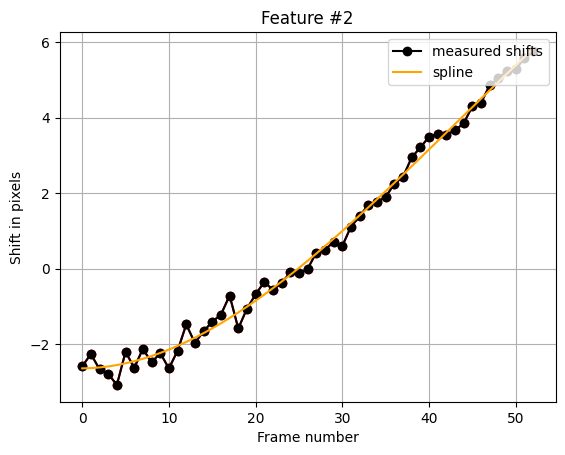

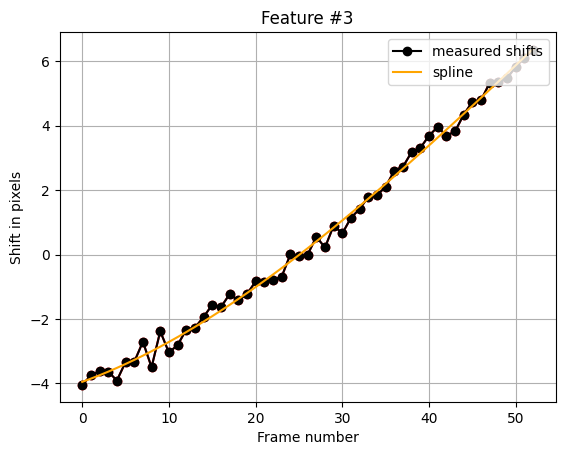

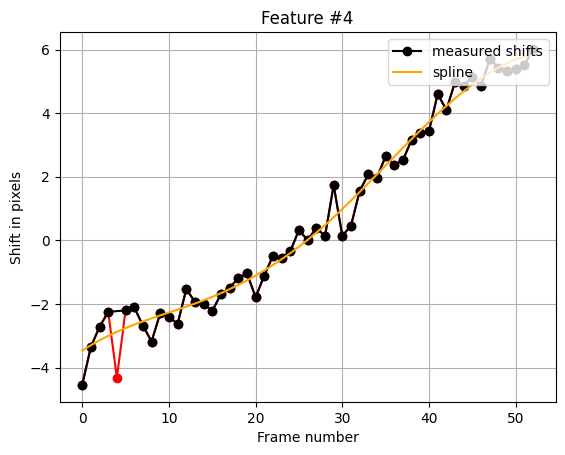

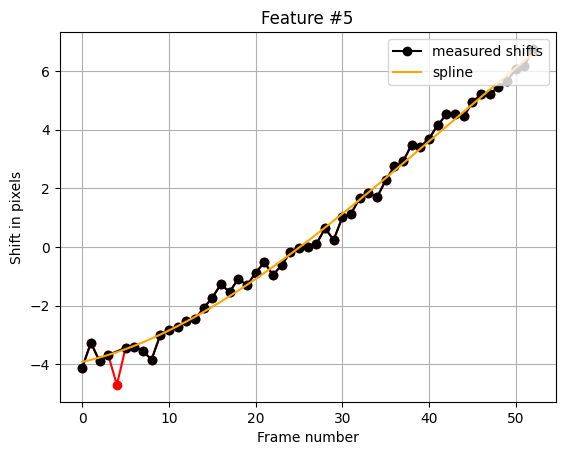

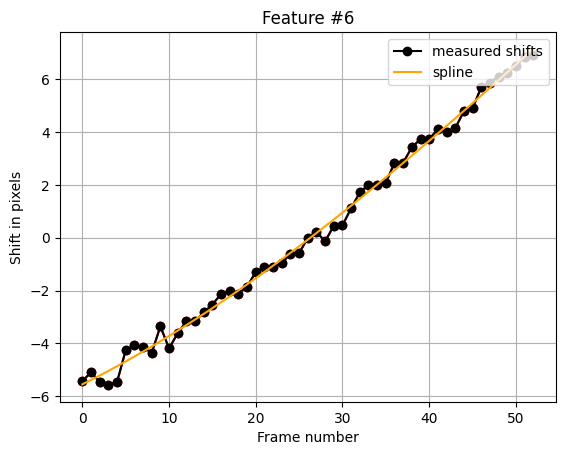

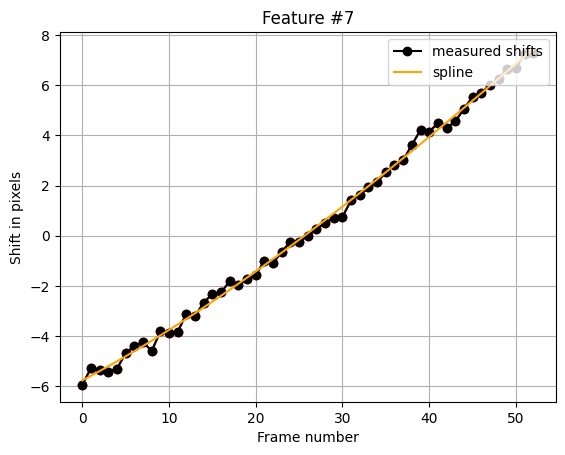

# lines used = 7
PIXEL SOLUTION PLOT FOR FRAME 0


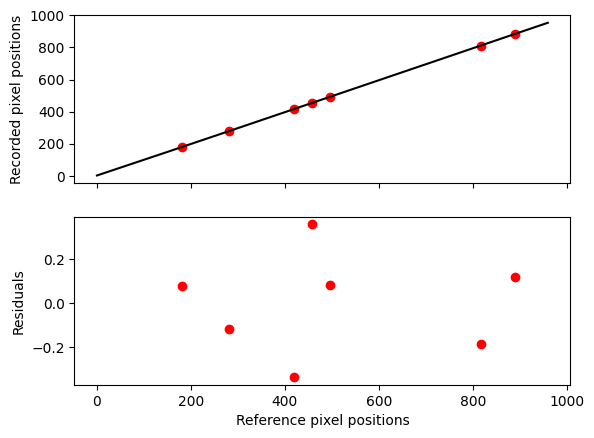

PIXEL SOLUTION PLOT FOR FRAME 52


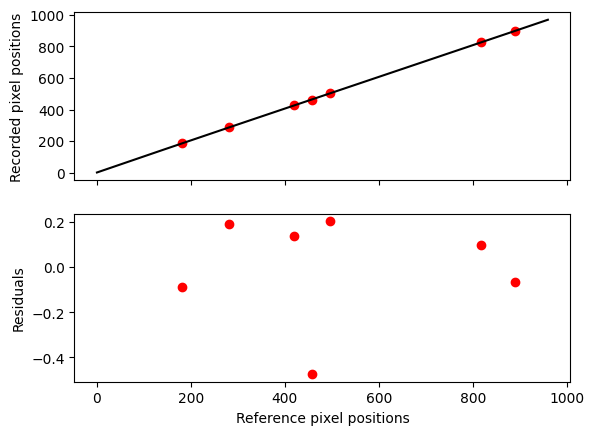

In [53]:
import importlib
importlib.reload(wc)

sigma_clip_outliers = 3
median = False
poly_order = 3
mf_box_width = None
min_good = 0.9
spline_smoothing_factor = 9
verbose = True
refit_polynomial = None
use_pysynphot = True

resampled_star1, n_lines_used_1, smooth_shifts_1, lines_used_1 = wc.resample_smoothly(
    reference_lines,
    star1_cc_line_shifts,  # filter shifts too
    input1,
    sigma_clip_outliers = sigma_clip_outliers ,
    median = median,
    poly_order = poly_order,
    mf_box_width = mf_box_width,
    min_good = min_good,
    spline_smoothing_factor = spline_smoothing_factor,
    verbose = verbose,
    refit_polynomial = refit_polynomial,
    use_pysynphot = use_pysynphot
)


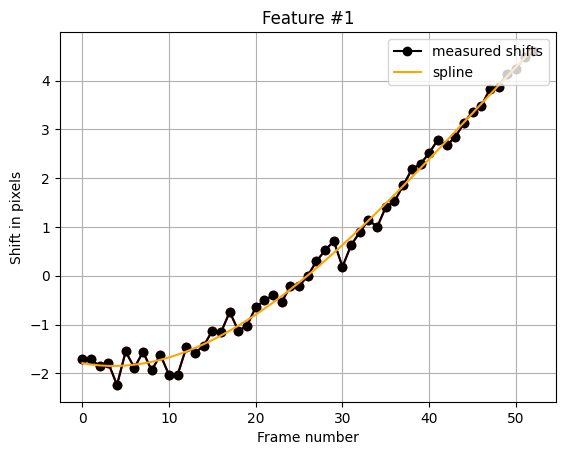

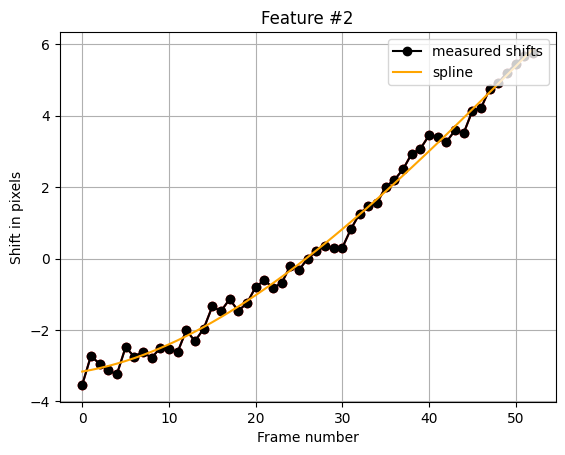

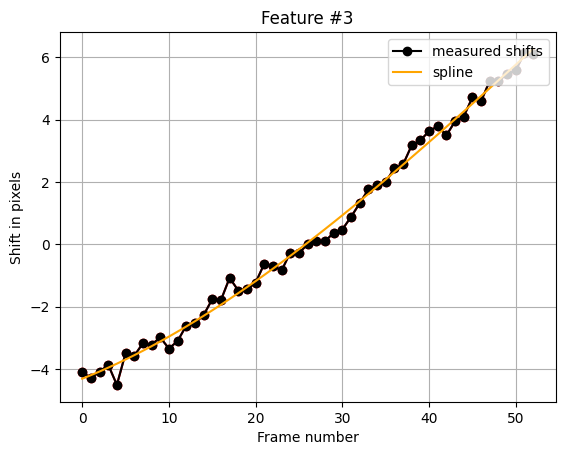

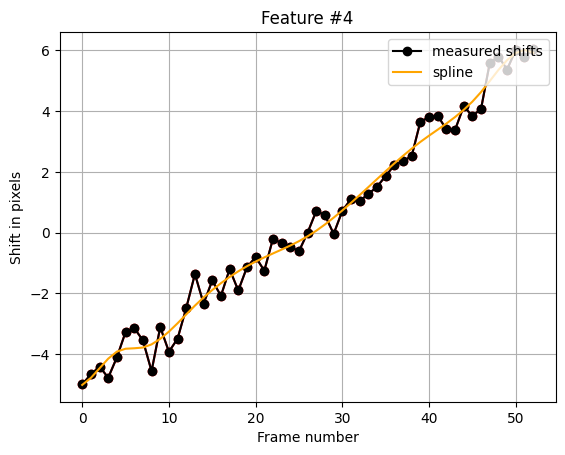

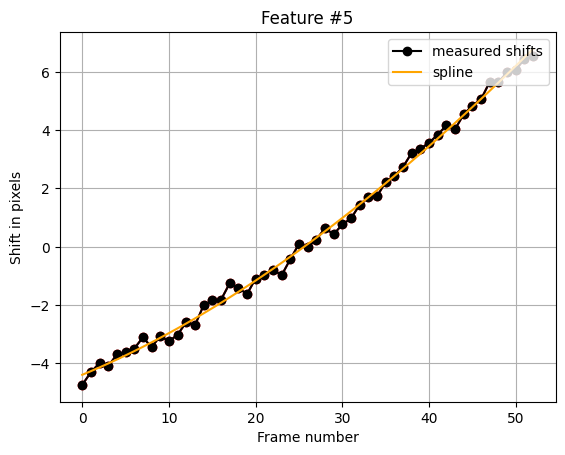

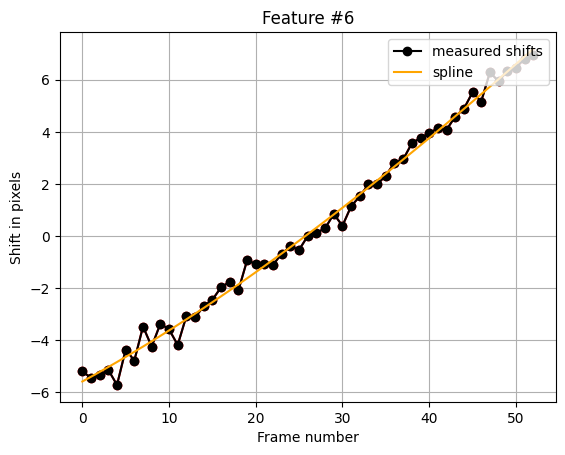

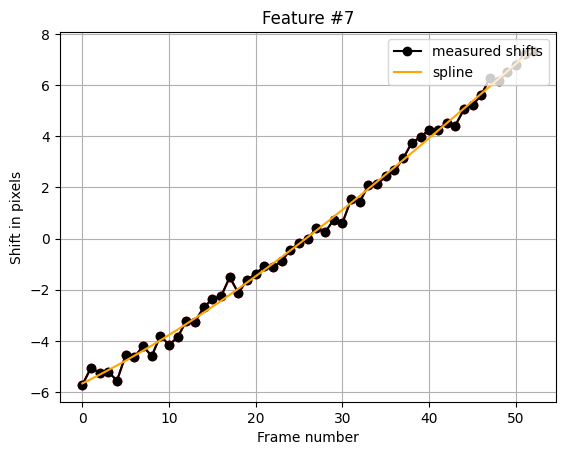

# lines used = 7
PIXEL SOLUTION PLOT FOR FRAME 0


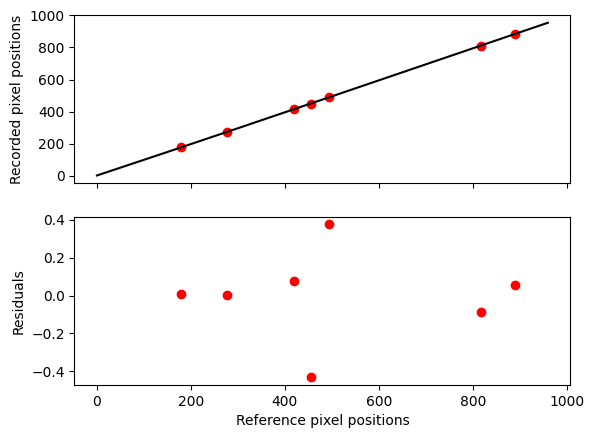

PIXEL SOLUTION PLOT FOR FRAME 52


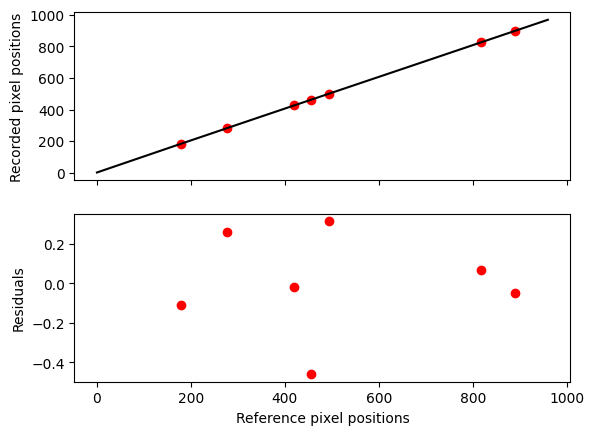

In [54]:
import importlib
importlib.reload(wc)

ref_lines = reference_lines
ref_lines = np.array([224.63084419,317.10748764,458.47427118,533.07395384,854.99359717,927.4991501])
ref_lines = np.array([180,277.56158943,419.42758403,454.7843833,494.32885978,817.14832275,889.6262784])

sigma_clip_outliers = 3
median = False
poly_order = 3
mf_box_width = None
min_good = 0.9
spline_smoothing_factor = 9
verbose = True
refit_polynomial = None
use_pysynphot = True


resampled_star2, n_lines_used_2, smooth_shifts_2, lines_used_2 = wc.resample_smoothly(
    ref_lines,
    star2_cc_line_shifts,  # filter shifts too
    input2,
    sigma_clip_outliers = sigma_clip_outliers ,
    median = median,
    poly_order = poly_order,
    mf_box_width = mf_box_width,
    min_good = min_good,
    spline_smoothing_factor = spline_smoothing_factor,
    verbose = verbose,
    refit_polynomial = refit_polynomial,
    use_pysynphot = use_pysynphot
)

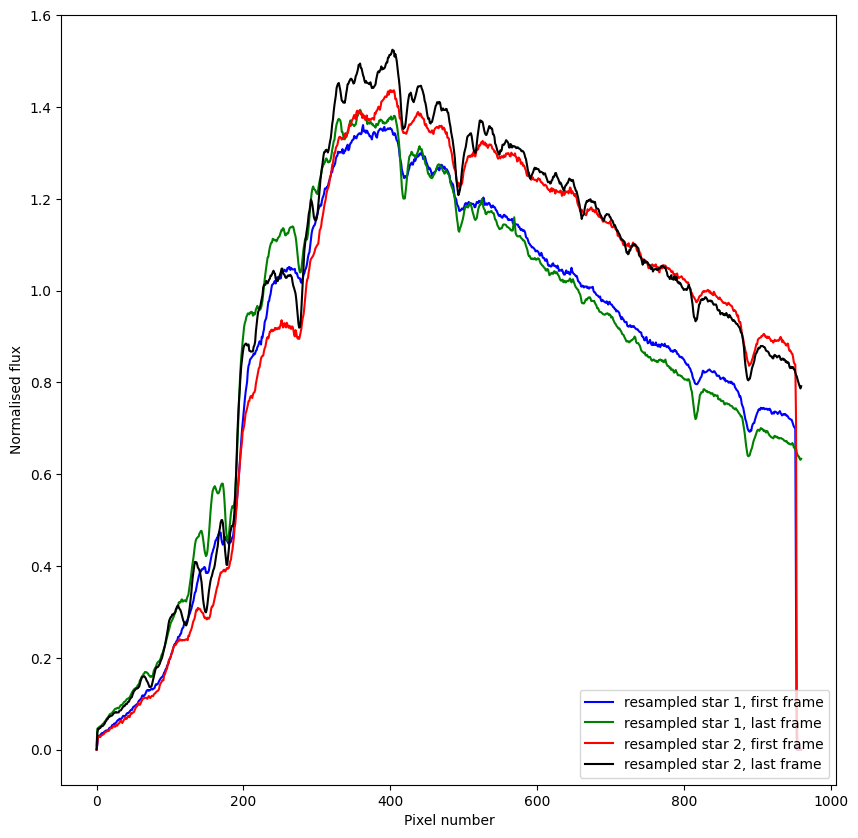

In [55]:
plt.figure(figsize=(10, 10))
plt.plot(0.95*wc.normalise(resampled_star1['flux'][0]),'b',label='resampled star 1, first frame')
plt.plot(0.95*wc.normalise(resampled_star1['flux'][-1]),'g',label='resampled star 1, last frame')

plt.plot(1.05*wc.normalise(resampled_star2['flux'][0]),'r',label='resampled star 2, first frame')
plt.plot(1.05*wc.normalise(resampled_star2['flux'][-1]),'k',label='resampled star 2, last frame')

plt.ylabel('Normalised flux')
plt.xlabel('Pixel number')
plt.legend(loc='lower right')
plt.show()

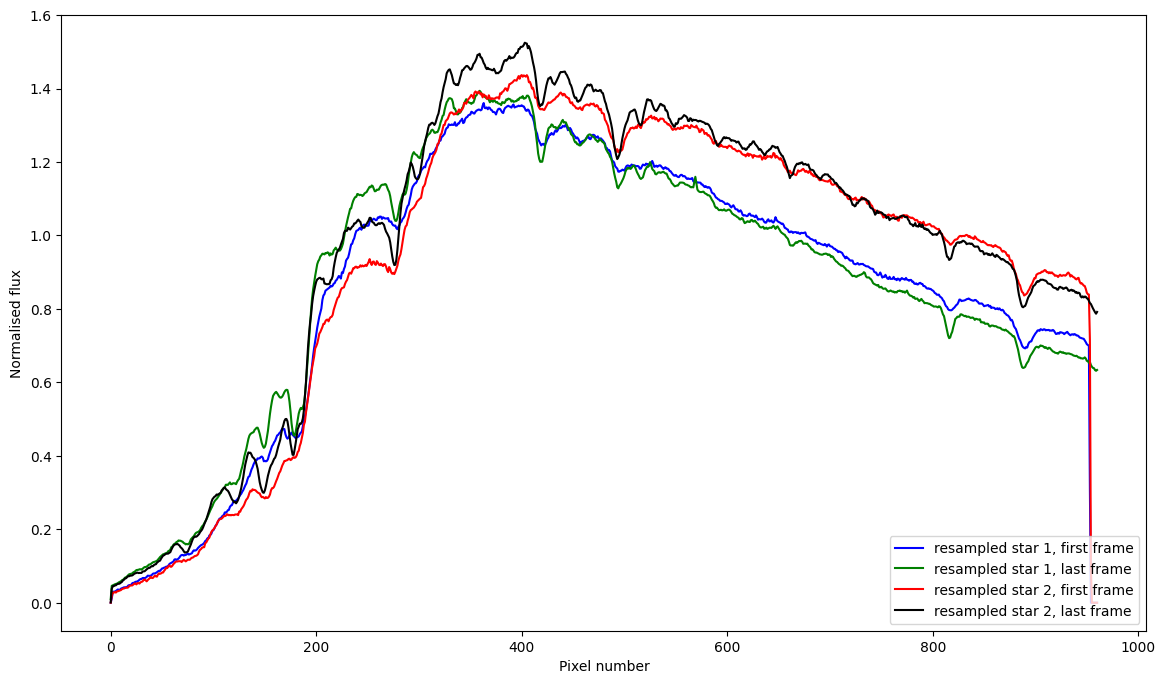

In [56]:
plt.figure(figsize=(14, 8))
plt.plot(0.95*wc.normalise(resampled_star1['flux'][0]),'b',label='resampled star 1, first frame')
plt.plot(0.95*wc.normalise(resampled_star1['flux'][-1]),'g',label='resampled star 1, last frame')

plt.plot(1.05*wc.normalise(resampled_star2['flux'][0]),'r',label='resampled star 2, first frame')
plt.plot(1.05*wc.normalise(resampled_star2['flux'][-1]),'k',label='resampled star 2, last frame')

plt.ylabel('Normalised flux')
plt.xlabel('Pixel number')
plt.legend(loc='lower right')
plt.show()

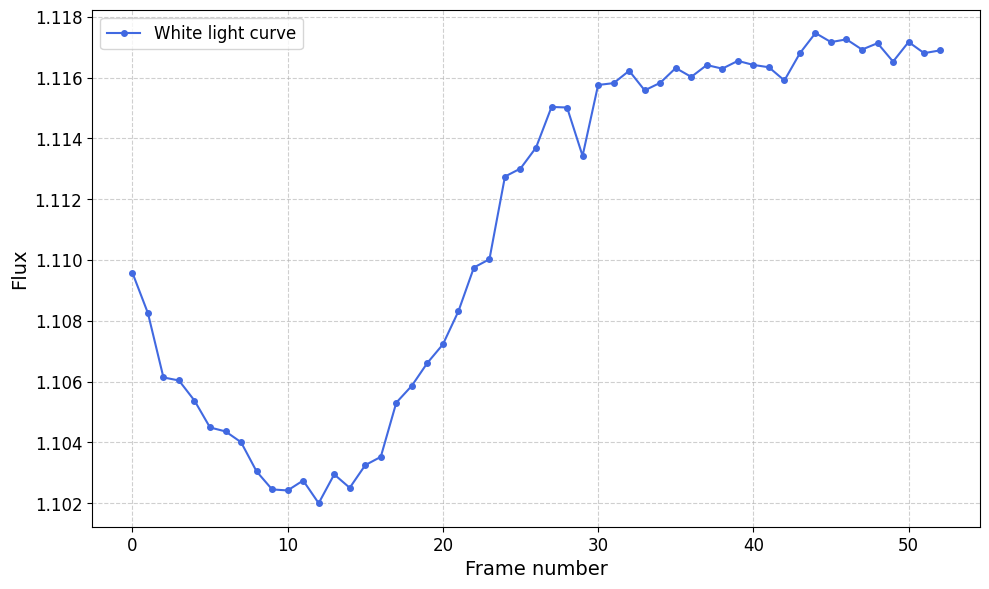

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data
_, pre_f, pre_e = np.loadtxt(parent_direc + 'white_light.dat', unpack=True)

# Plot with improved appearance
plt.figure(figsize=(10, 6))  # Bigger plot (10 inches x 6 inches)
plt.plot(pre_f, marker='o', linestyle='-', markersize=4, color='royalblue', label='White light curve')

# Axis labels
plt.xlabel('Frame number', fontsize=14)
plt.ylabel('Flux', fontsize=14)

# Grid and ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: Add a legend
plt.legend(fontsize=12)

# Tight layout for spacing
plt.tight_layout()

# Show the plot
plt.show()

In [58]:
contact1 = 0
contact4 = 29

Now using these positions, we can normalise the light curve to the out of transit data.

In [59]:
no_resampling_flux = pre_f/np.nanmedian(pre_f[:contact1].tolist()+pre_f[contact4:].tolist())
no_resampling_error = (pre_e/pre_f) * no_resampling_flux

And calculate the white light curve for the resampled data

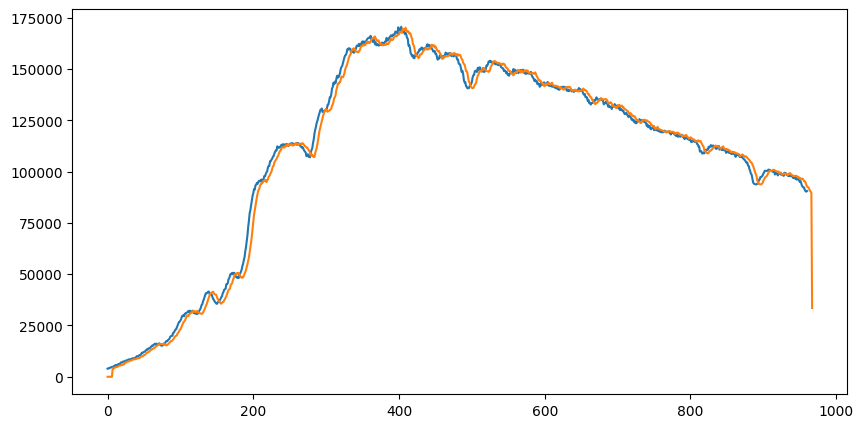

In [60]:
plt.figure(figsize=(10, 5))
arr = resampled_star2['flux'][27]
padded_arr = np.pad(arr, (7, 0), mode='constant', constant_values=0)
plt.plot(star2_clean[27])
plt.plot(padded_arr)

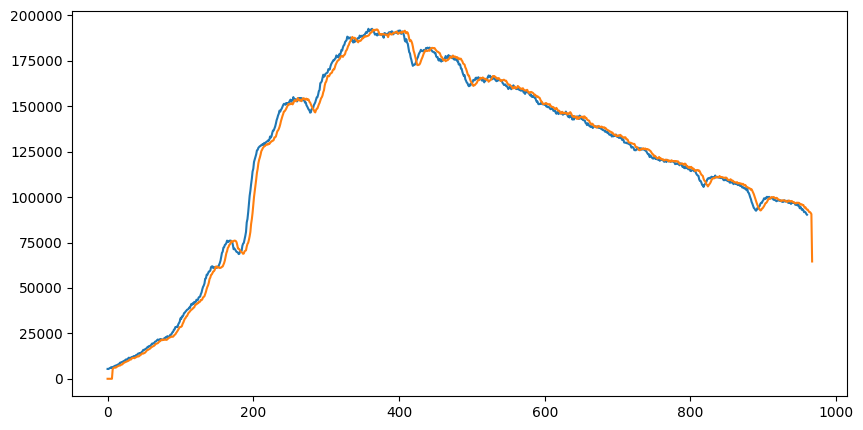

In [139]:
plt.figure(figsize=(10, 5))
arr = resampled_star1['flux'][27]
padded_arr = np.pad(arr, (7, 0), mode='constant', constant_values=0)
plt.plot(star1_clean[27])
plt.plot(padded_arr)

In [61]:
np.mean(star1_clean[27]),np.mean(resampled_star1['flux'][27]),np.mean(star2_clean[27]),np.mean(resampled_star2['flux'][27])
np.mean(resampled_star1['flux'][27])/np.mean(star1_clean[27]),np.mean(resampled_star2['flux'][27])/np.mean(star2_clean[27])

(1.0007066716436095, 1.0001955794664068)

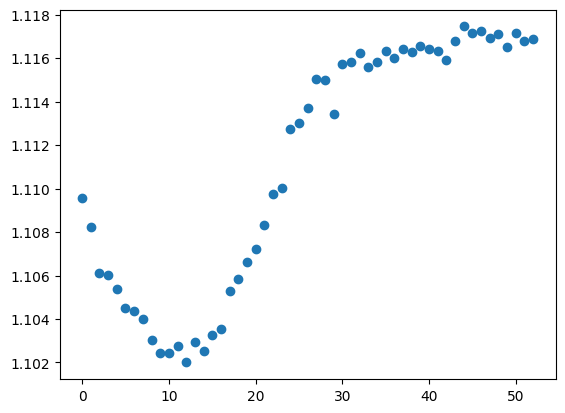

In [62]:

plt.plot((star1_clean).sum(axis=1)/(star2_clean).sum(axis=1),'o')

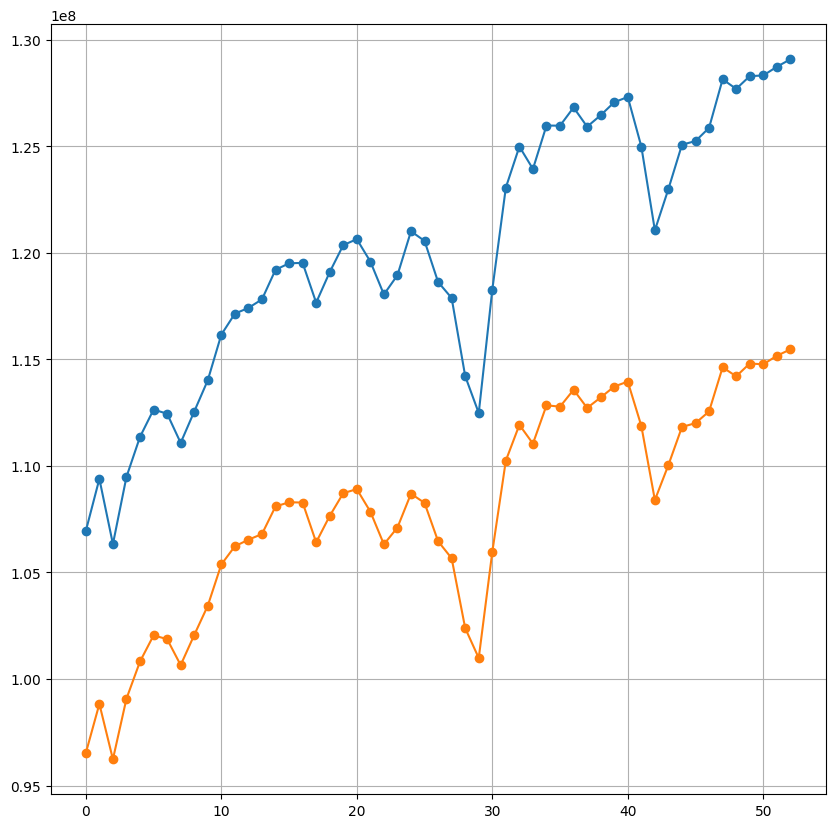

In [63]:
plt.figure(figsize=(10, 10))
plt.plot((resampled_star1['flux']).sum(axis=1),'o-')
plt.plot((resampled_star2['flux']).sum(axis=1),'o-')
plt.grid()

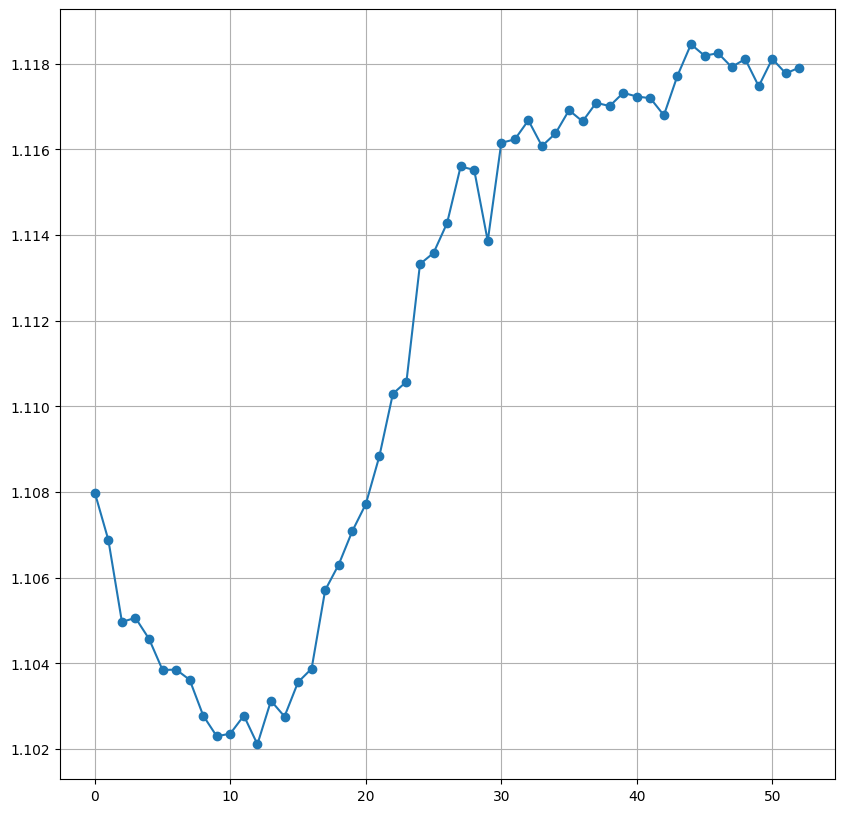

In [64]:
# Plot star1
plt.figure(figsize=(10, 10))
plt.grid()
#im1 = plt.imshow(wc.normalise(resampled_star1['flux']), aspect='auto', origin='lower')
aa = np.array(resampled_star1['flux']).sum(axis=1)/np.array(resampled_star2['flux']).sum(axis=1)
plt.plot(aa,'-o')
plt.show()

RMS: post-resampling/pre-resampling = 1.22 


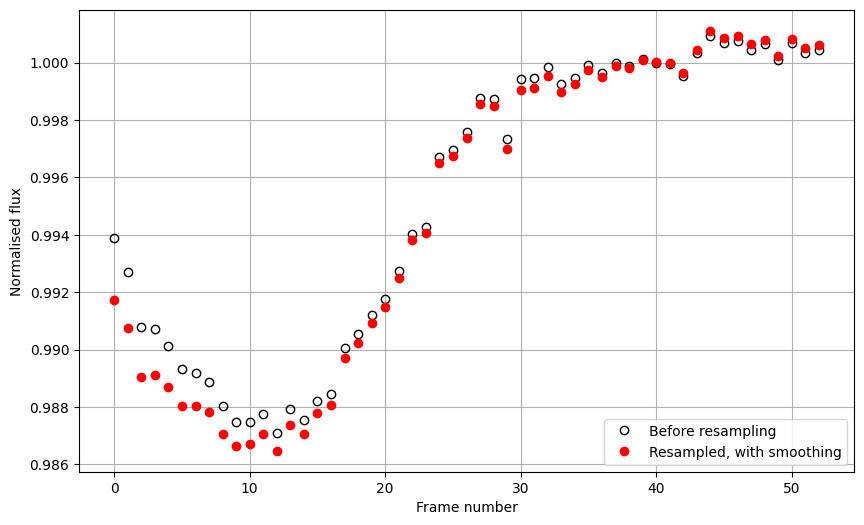

In [65]:
resampled_flux_smoothing = np.array(resampled_star1['flux']).sum(axis=1)/np.array(resampled_star2['flux']).sum(axis=1)
resampled_flux_smoothing = resampled_flux_smoothing/np.nanmedian(np.hstack((resampled_flux_smoothing[:contact1],resampled_flux_smoothing[contact4:])))

no_resampling_flux = pre_f/np.nanmedian(pre_f[:contact1].tolist()+pre_f[contact4:].tolist())
no_resampling_error = (pre_e/pre_f) * no_resampling_flux
rms_post = np.nanstd(resampled_flux_smoothing[contact4:])
rms_pre = np.nanstd(no_resampling_flux[contact4:])

# Now define the ratio of the noise in the white light curves
rms_wl_ratio = rms_post/rms_pre

print("RMS: post-resampling/pre-resampling = %.2f "%(rms_wl_ratio))

original_length = len(resampled_star1['flux'])
#bad_frames = [0]

# Create an empty array filled with NaNs
full_flux = np.full(original_length, np.nan)

# Get the indices of the good frames
#good_frames = np.setdiff1d(np.arange(original_length), bad_frames)

# Insert cleaned data into the correct positions
full_flux = resampled_flux_smoothing
resampled_flux_smoothing = full_flux

plt.figure(figsize=(10, 6))  # Bigger plot (10 inches x 6 inches)
plt.plot(no_resampling_flux,'ko',markerfacecolor='None',label='Before resampling')
plt.plot(resampled_flux_smoothing,'ro',label='Resampled, with smoothing')
plt.ylabel('Normalised flux')
plt.xlabel('Frame number')
plt.legend(loc='lower right')
plt.grid()
plt.show()

We also want to check how the noise compares in the spectroscopic light curves. To do this we need to first construct these light curves by splitting up the spectra into different pixel regions.

The pixel scale of EFOSC Gr#11 is 2.04A/pixel and we typically use wavelength bins around 250A wide.

https://www.eso.org/sci/facilities/lasilla/instruments/efosc/inst/Efosc2Grisms.html

In [66]:
# Define the pixel bins
pixel_bins = np.arange(0,len(star1[nframes//2]),200//2.04).astype(int)
nbins = len(pixel_bins)

Now split the spectra before and after resampling into the pixel bins, make light curves and compare the noise ratios as before.

In [67]:
# save the light curves that have worse noise
worse_noise = []

noise_ratio = []

for i in range(nbins-1):

    rf = resampled_star1['flux'][:,pixel_bins[i]:pixel_bins[i+1]].sum(axis=1)/resampled_star2['flux'][:,pixel_bins[i]:pixel_bins[i+1]].sum(axis=1)
    rf_norm = rf/np.nanmedian(rf[:contact1].tolist()+rf[contact4:].tolist())
    
    f = star1[:,pixel_bins[i]:pixel_bins[i+1]].sum(axis=1)/star2[:,pixel_bins[i]:pixel_bins[i+1]].sum(axis=1)
    f_norm = f/np.nanmedian(f[:contact1].tolist()+f[contact4:].tolist())

    if np.nanstd(rf_norm[contact4:])/np.nanstd(f_norm[contact4:]) > 1:
        worse_noise.append(i)
    
    noise_ratio.append(np.nanstd(rf_norm[contact4:])/np.nanstd(f_norm[contact4:]))
    
    print("Post/pre resampling = %.2f"%(np.nanstd(rf_norm[contact4:])/np.nanstd(f_norm[contact4:])))
    
print('\nFraction of bins that are worse = %.2f'%(len(worse_noise)/nbins))
print('Best noise ratio = %.2f; Worst noise ratio = %.2f; Median noise ratio = %.2f'%\
      (min(noise_ratio),max(noise_ratio),np.nanmedian(noise_ratio)))


resampled_flux_smoothing = np.array(resampled_star1['flux']).sum(axis=1)/np.array(resampled_star2['flux']).sum(axis=1)
resampled_flux_smoothing = resampled_flux_smoothing/np.nanmedian(np.hstack((resampled_flux_smoothing[:contact1],resampled_flux_smoothing[contact4:])))

no_resampling_flux = pre_f/np.nanmedian(pre_f[:contact1].tolist()+pre_f[contact4:].tolist())
no_resampling_error = (pre_e/pre_f) * no_resampling_flux
rms_post = np.nanstd(resampled_flux_smoothing[contact4:])
rms_pre = np.nanstd(no_resampling_flux[contact4:])

# Now define the ratio of the noise in the white light curves
rms_wl_ratio = rms_post/rms_pre


Post/pre resampling = 1.13
Post/pre resampling = 0.86
Post/pre resampling = 1.11
Post/pre resampling = 0.57
Post/pre resampling = 0.76
Post/pre resampling = 0.30
Post/pre resampling = 0.86
Post/pre resampling = 1.08
Post/pre resampling = 0.98

Fraction of bins that are worse = 0.30
Best noise ratio = 0.30; Worst noise ratio = 1.13; Median noise ratio = 0.86


In [68]:
trial = 3
box_width = 30
tolerance = 15

In [69]:
results = np.array([trial,box_width,tolerance,min_good,sigma_clip_outliers,median,poly_order,\
                    mf_box_width,min_good,spline_smoothing_factor,refit_polynomial,\
                    n_lines_used_1,n_lines_used_2,np.round(rms_wl_ratio,2),np.round(len(worse_noise)/nbins,2),\
                    np.round(min(noise_ratio),2),np.round(max(noise_ratio),2),np.round(np.median(noise_ratio),2)])

In [70]:
separator = '|'
output = '|'+separator.join(results.astype(str))+'|'
print(output)

|3|30|15|0.9|3|False|3|None|0.9|9|None|7|7|1.22|0.3|0.3|1.13|0.86|


In [137]:
#output_all = []

|Trial|box width|tolerance|min good|sigma clip outliers|median filter|poly order|median filter box width|min good|spline smoothing factor|refit polynomial|n lines used 1|n lines used 2|rms wl ratio|Fraction of bins that are worse|Min. noise ratio|Max. noise ration|Median noise ratio|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|1|60|10|0.9|3|False|1|None|0.9|None|None|11|9|1.06|0.61|0.73|1.22|1.01|



If happy, dump them

In [71]:
resampled_star1['flux'].shape

(53, 961)

In [72]:
pickle.dump(resampled_star1['flux'],open(parent_direc+'pickled_objects/improved_resampling/star1_flux_resampled.pickle','wb'))
pickle.dump(resampled_star1['error'],open(parent_direc+'pickled_objects/improved_resampling/star1_error_resampled.pickle','wb'))
pickle.dump(resampled_star1['xposition'],open(parent_direc+'pickled_objects/improved_resampling/xpos1_resampled.pickle','wb'))
pickle.dump(resampled_star1['sky'],open(parent_direc+'pickled_objects/improved_resampling/sky1_resampled.pickle','wb'))

pickle.dump(resampled_star2['flux'],open(parent_direc+'pickled_objects/improved_resampling/star2_flux_resampled.pickle','wb'))
pickle.dump(resampled_star2['error'],open(parent_direc+'pickled_objects/improved_resampling/star2_error_resampled.pickle','wb'))
pickle.dump(resampled_star2['xposition'],open(parent_direc+'pickled_objects/improved_resampling/xpos2_resampled.pickle','wb'))
pickle.dump(resampled_star2['sky'],open(parent_direc+'pickled_objects/improved_resampling/sky2_resampled.pickle','wb'))

pickle.dump(ref_lines,open(parent_direc+'pickled_objects/improved_resampling/ref_lines.pickle','wb'))

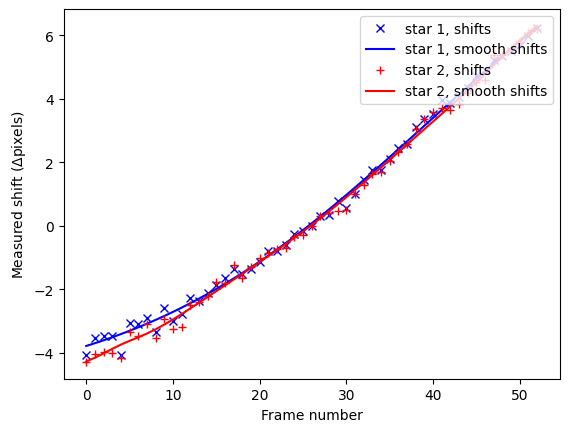

In [73]:
ypos1_smooth = np.nanmean(smooth_shifts_1,axis=1)
ypos1 = np.nanmean(star1_cc_line_shifts,axis=1)

ypos2_smooth = np.nanmean(smooth_shifts_2,axis=1)
ypos2 = np.nanmean(star2_cc_line_shifts,axis=1)

plt.figure()

plt.plot(ypos1,'bx',label='star 1, shifts')
plt.plot(ypos1_smooth,'b',label='star 1, smooth shifts')


plt.plot(ypos2,'r+',label='star 2, shifts')
plt.plot(ypos2_smooth,'r',label='star 2, smooth shifts')

plt.ylabel('Measured shift ($\Delta$pixels)')
plt.xlabel('Frame number')

plt.legend(loc='upper right')

plt.show()

In [74]:
pickle.dump(ypos1,open(parent_direc+'pickled_objects/ypos1.pickle','wb'))
pickle.dump(ypos1_smooth,open(parent_direc+'pickled_objects/ypos1_smooth.pickle','wb'))

pickle.dump(ypos2,open(parent_direc+'pickled_objects/ypos2.pickle','wb'))
pickle.dump(ypos2_smooth,open(parent_direc+'pickled_objects/ypos2_smooth.pickle','wb'))